# Телеком

Целью проекта является построение модели машинного обучения, предсказывающей возможное расторжение договора с оператором  связи «ТелеДом», для оптимизации работы компании по предотвращению оттока клиентов.    

Для построения модели предсказаний компанией предоставлены персональные данные о клиентах, информация об их тарифах и услугах. 

Импортируем необходимые библиотеки и их модули

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import catboost as cb
import tensorflow as tf
import phik
import warnings
warnings.filterwarnings('ignore')

from sqlalchemy import create_engine 
from tensorflow import keras
from tensorflow.keras.metrics import AUC
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout 

from numpy.random import RandomState

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn. metrics import precision_recall_curve
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from phik.report import plot_correlation_matrix
from phik import report

Задаем константу RANDOM_STATE в соответствии с условием проекта - дата начала работы над проектом 28.06.2023.

In [2]:
RANDOM_STATE = 280623

Подключаемся к базе данных

In [3]:
db_config = {
             'user': 'praktikum_student',# имя пользователя,
             'pwd': 'Sdf4$2;d-d30pp',# пароль,
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432,# порт подключения,
              'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string) 

Для прочтения данных из базы данных с помощью языка SQL применим метод pd.read_sql_query библиотеки pandas, который выполнит SQL-запрос к предоставленным заказчиком базам и загрузит результат в DataFrame в соответствии с назначенными переменными. 

In [5]:
# читаем telecom.contract
query = '''
SELECT *
FROM telecom.contract; 
'''
contract_original = pd.read_sql_query(query, con=engine) 

# читаем telecom.personal
query = '''
SELECT *
FROM telecom.personal; 
'''
personal = pd.read_sql_query(query, con=engine) 

# читаем telecom.internet
query = '''
SELECT *
FROM telecom.internet; 
'''
internet = pd.read_sql_query(query, con=engine) 

# читаем telecom.phone
query = '''
SELECT *
FROM telecom.phone; 
'''
phone = pd.read_sql_query(query, con=engine) 

## Исследовательский анализ и предобработка данных

Данные прочитаны, каждая таблица сохранена в переменной. Для изучения данных и минимизации дублирования кодов пишем функцию, которая выведет первые строки, информацию об объеме данных, пропусках, полных дубликатах.

In [6]:
def study(df):
    display(df.head())
    df.info()
    print('')
    print('Найдено пропусков:')
    print(df.isna().sum())
    print('')
    print('Найдено дубликатов:',df.duplicated().sum())
   

 Таблица <b>contract_original</b>

In [7]:
study(contract_original)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB

Найдено пропусков:
customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

Найдено дубликатов: 0


В таблице contract насчитывается 7043 объекта и 8 столбцов, 6 из которых представлены типом object, 2 - float64. Данные имеют пропуски в двух столбцах: EndDate -5174 пропуска и TotalCharges -11. Полные дубликаты отсутствуют. 
-  Наименования столбцов требуют приведения к общепринятому формату - нижнему регистру с разделением составных наименований нижней чертой. 
-  Столбцы с датами оформления и расторжения контрактов (BeginDate и EndDate) представлены типом object и требуют переведения в тип datetime.
-  В столбцах EndDate и TotalCharges необходима адекватная замена пропусков.  

Перед началом всех преобразований создадим копию для сохранения первоначальных данных.

In [8]:
contract = contract_original.copy()
contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15


Приводим к общепринятому формату наименования столбцов.

In [9]:
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing','payment_method', 'monthly_charges',
                    'total_charges']
contract.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15


In [10]:
# Проверяем наличие дубликатов по 'customer_id'

print('Количество дубликатов:', contract['customer_id'].duplicated().sum())

Количество дубликатов: 0


Перед тем как менять тип данных создадим на основе признака 'end_date' столбец с целевой переменной. Будем исходить из того, что если имеется дата окончания действия договора - то абонент ушел от этого оператора, если данных нет - то продолжает оставаться абонентом.

Напишем функцию, которая данным об окончании договора присвоит значение 1, в ином случае - значение 0. Применим функцию к столбцу 'end_date' и создадим столбец 'target'.

In [11]:
# пишем функцию

def end_date(row):
    
    if row is None:
        return 0
    return 1

# создаем столбец с целевой переменной
contract['target'] = contract['end_date'].apply(end_date)

In [12]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [13]:
contract['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

Целевая переменная создана, количество объектов со значением 1 (1869) ровно столько, сколько было ненулевых объектов в столбце 'end_date'

Теперь сгенерируем признак 'duration_contracts' (длительность договора в днях), который передадим для обучения модели. Для этого cделаем следующее:
-  изменим тип данных на datetime в столбцах 'begin_date' и 'end_date';
-  на основе 'end_date' создадим столбец 'duration_contracts'путем вычитания 'begin_date' из  'end_date', для действующих абонентов датой окончания договора установим дату выгрузки базы 01.02.2020.

In [14]:
# преобразование столбца BeginDate в тип даты to_datetime
contract['begin_date'] = pd.to_datetime(contract['begin_date'])
contract['end_date'] = pd.to_datetime(contract['end_date'])

contract['end_date'] = contract['end_date'].fillna(pd.to_datetime('01-02-2020', format='%d-%m-%Y'))
contract['duration_contracts'] = (contract['end_date'] - contract['begin_date']).dt.days

In [15]:
# смотрим адекватность замены
display(contract.tail())
contract.info()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration_contracts
7038,2569-WGERO,2019-01-21,2020-02-01,Two year,Yes,Bank transfer (automatic),21.15,1419.40,0,376
7039,6840-RESVB,2019-02-26,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,340
7040,2234-XADUH,2019-09-02,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,152
7041,4801-JZAZL,2019-06-26,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,220
7042,3186-AJIEK,2019-04-18,2020-02-01,Two year,Yes,Bank transfer (automatic),105.65,6844.50,0,289


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         7043 non-null   object        
 1   begin_date          7043 non-null   datetime64[ns]
 2   end_date            7043 non-null   datetime64[ns]
 3   type                7043 non-null   object        
 4   paperless_billing   7043 non-null   object        
 5   payment_method      7043 non-null   object        
 6   monthly_charges     7043 non-null   float64       
 7   total_charges       7032 non-null   float64       
 8   target              7043 non-null   int64         
 9   duration_contracts  7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


In [16]:
contract['duration_contracts']

0         0
1         0
2       479
3         0
4       279
       ... 
7038    376
7039    340
7040    152
7041    220
7042    289
Name: duration_contracts, Length: 7043, dtype: int64

Мы добавили в таблицу новый столбец 'duration_contracts', в котором получили значения длительности договоров для абонентов в днях. 

Конечно, к данному признаку можно отнестись критически, поскольку абоненты, которые растогрли договор, могли быть клиентами компании более года, а действующие - всего несколько дней. Но возможно будущим моделям предсказаний  удастся уловить правильную взаимосвязь между этим признаком и такими как тип оплаты, ежемесячные и общие расходы и повысить качество предсказаний.

В столбце 'total_charges' (общие расходы абонента за связь) 11 пропущенных значений. Посмотрим на самую раннюю и самую позднюю даты заключения договоров, найдем данные об абонентах с отсутствующими расходами за связь.

In [17]:
print('Дата самого раннего заключения договора:', contract['begin_date'].min().date())
print('Дата самого позднего заключения договора:', contract['begin_date'].max().date())

Дата самого раннего заключения договора: 2018-04-17
Дата самого позднего заключения договора: 2020-02-01


In [18]:
contract[contract['total_charges'].isnull()] 

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration_contracts
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
6,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
7,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
9,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
10,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
11,2775-SEFEE,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),61.90,NaN,0,0
4408,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
5160,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0


У всех этих клиентов по столбцу 'begin_date' (дата начала действия договора) указано значение 2020-02-01, что соответствует по условию проекта дате выгрузки базы данных - 1 февраля 2020, то есть в день подписания клиентами договора. Это может означать что у них еще не было расходов на связь. Значит пропуски можно заменить нулевыми значениями.

In [19]:
# замена пропусков
contract['total_charges'] = contract['total_charges'].fillna('0').astype('float64') 

Проверяем как изменилcя датафрейме

In [20]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         7043 non-null   object        
 1   begin_date          7043 non-null   datetime64[ns]
 2   end_date            7043 non-null   datetime64[ns]
 3   type                7043 non-null   object        
 4   paperless_billing   7043 non-null   object        
 5   payment_method      7043 non-null   object        
 6   monthly_charges     7043 non-null   float64       
 7   total_charges       7043 non-null   float64       
 8   target              7043 non-null   int64         
 9   duration_contracts  7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


In [21]:
contract.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration_contracts
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.00,0,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.00,0,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,479


Наименования столбцов приведены к общепринятому формату, типы данных столбцов 'begin_date' и 'end_date' изменены на datetime64, в столбце 'total_charges' пропуски заменены нулевыми значениями, сгенерированы новый признак 'duration_contracts' с данными о длительности договоров (в днях) и целевая переменная 'target', где 1 - абонент ушел от оператора связи, 0 - продолжает оставаться клиентом компании.

На основании целевого признака найдем соотношение классов целевого признака - долю абонентов, расторгнувших договор с компанией и визуализируем данные.

,target
0,5174
1,1869


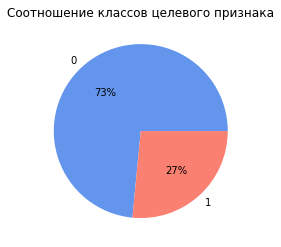

In [22]:
display(pd.DataFrame(contract['target'].value_counts()))
ct = contract.groupby('target').size()
ct.plot(kind='pie', subplots=True, colors = ['cornflowerblue', 'salmon'],autopct='%1.0f%%', figsize=(4, 4))
plt.title("Соотношение классов целевого признака")
plt.ylabel("")
plt.show()

Соотношение классов целевого признака составляет примерно 1/3, где 27% составляет положительный класс (абоненты расторгли договор) и 73% - отрицательный (действующие абоненты).

Для определения признаков, которые мы передадим для обучения будущей модели, определим взаимосвязь между каждым из них и целевой переменной. Для визуализации исследования создадим два рабочих датафрейма с данными о действующих абонентах (yes_contract) и тех, кто ушел от оператора связи (no_contract).

In [23]:
# создаем рабочие датафреймы

no_contract = contract.query('target == 1')
yes_contract = contract.query('target == 0')

Изучим распределение данных в новом сгенерированном признаке 'duration_contracts'. 

Распределение данных по действующим абонентам не имеет смысла смотреть из-за принудительности даты окончания договора. Гораздо интереснее знать распределение длительности  расторгнутых договоров.

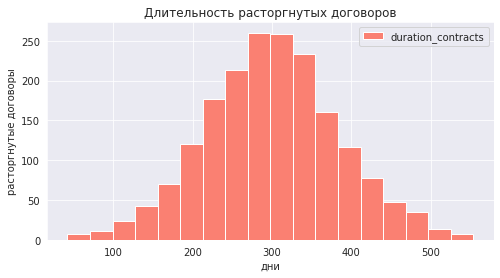

In [24]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1, 1)
no_contract['duration_contracts'].hist(bins = 18, grid = True, legend = 'duration_contracts', color='salmon',figsize = (8,4))
ax.set_title("Длительность расторгнутых договоров")
ax.set_xlabel('дни')
ax=ax.set_ylabel('расторгнутые договоры')  

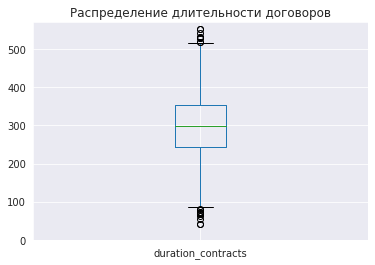

In [25]:
plt.ylim(0, 570)
ax=no_contract.boxplot(['duration_contracts'])
ax = ax.set_title('Распределение длительности договоров')

In [26]:
no_contract['duration_contracts'].describe() 

count    1869.000000
mean      299.982879
std        84.423849
min        42.000000
25%       244.000000
50%       299.000000
75%       353.000000
max       554.000000
Name: duration_contracts, dtype: float64

-  Гистограмма длительности расторгнутых договоров и основные описательные статистики показывают, что самый маленький по длительности договор составляет чуть более месяца (42 дня). Максимальный период договора, который был расторгнут составляет 554 дня (около 1.5 лет). Наиболее часто расторгаются договоры по истечении примерно 8-11 месяцев.

Изучим какие типы оплаты предпочитают действующие абоненты компании и ушедшие. 

In [27]:
# группируем данные по действующим абонентам
yes_contract_type = pd.DataFrame(yes_contract['type'].value_counts()).reset_index()
yes_contract_type.columns = ['type_values', 'counts']
yes_contract_type

,type_values,counts
0,Month-to-month,2220
1,Two year,1647
2,One year,1307


In [28]:
# группируем данные по ушедшим абонентам

no_contract_type = pd.DataFrame(no_contract['type'].value_counts()).reset_index()
no_contract_type.columns = ['type_values', 'counts']
no_contract_type

,type_values,counts
0,Month-to-month,1655
1,One year,166
2,Two year,48


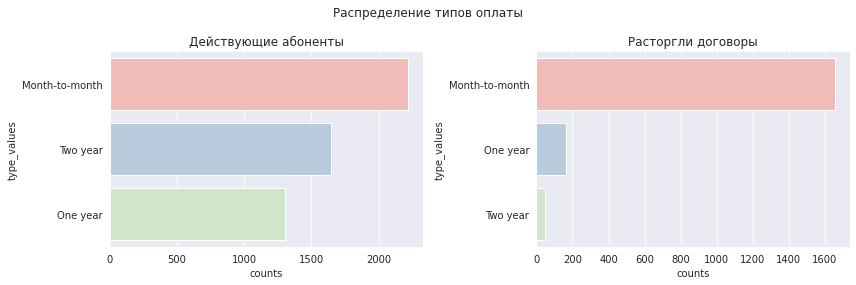

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 4])
sns.barplot(x='counts', y='type_values', data=yes_contract_type, palette='Pastel1', ax=ax1)
ax1.set_title('Действующие абоненты')
sns.barplot(x='counts', y='type_values', data=no_contract_type, palette='Pastel1', ax=ax2)
ax2.set_title('Расторгли договоры')
plt.suptitle('Распределение типов оплаты')
plt.tight_layout()
plt.show()

-  Можно сказать что почти все абоненты, которые расторгли договор с оператором связи (1655), имели ежемесячный тип платежа. Количество тех, кто внес оплату на год вперед в десять раз меньше (166) и еще меньше тех, кто оплатил услуги на два года вперед.
-  Иное распределение данных у действующих абонентов. Наибольшее их количество тоже платит ежемесячно (2220). Однако, доля тех, кто заплатил на год и на два вперед в своей совокупности составляют около 60 % от их общего числа (2954).
-  Из этого следует вывод, что тип оплаты является значимым признаком для модели предсказания ухода абонента. 

Рассмотрим распределение данных о системах оплаты услуг связи. 

<b>paperless_billing</b>

In [30]:
# группируем данные по действующим абонентам
yes_contract_pb = pd.DataFrame(yes_contract['paperless_billing'].value_counts()).reset_index()
yes_contract_pb.columns = ['paperless_billing', 'counts']
yes_contract_pb

,paperless_billing,counts
0,Yes,2771
1,No,2403


In [31]:
# группируем данные по ушедщим абонентам
no_contract_pb = pd.DataFrame(no_contract['paperless_billing'].value_counts()).reset_index()
no_contract_pb.columns = ['paperless_billing', 'counts']
no_contract_pb

,paperless_billing,counts
0,Yes,1400
1,No,469


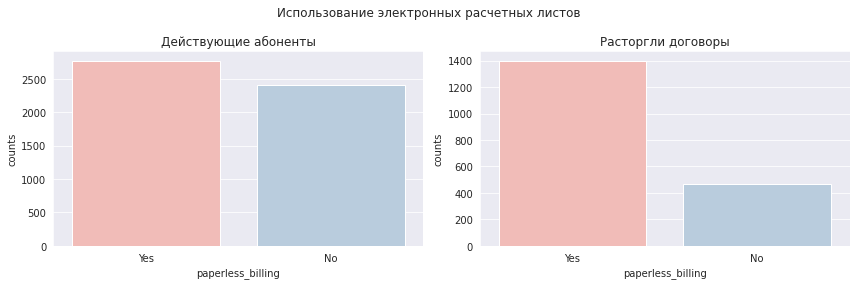

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 4])
sns.barplot(x='paperless_billing', y='counts', data=yes_contract_pb, palette='Pastel1', ax=ax1)
ax1.set_title('Действующие абоненты')
sns.barplot(x='paperless_billing', y='counts', data=no_contract_pb, palette='Pastel1', ax=ax2)
ax2.set_title('Расторгли договоры')
plt.suptitle('Использование электронных расчетных листов')
plt.tight_layout()
plt.show()

-  Действующие абоненты почти в равной степени пользуются электронными расчетными счетами и отказываются от них. 
-  Среди абонентов, которые растнорги договоры количество тех, кто предпочитал электронные расчетные листы почти в три раза больше тех, кто их не использовал (1400 и 460 соответственно).
-  В указанной связи признак 'paperless_billing' можно считать значимым.

<b>payment_method</b>

In [33]:
# группируем данные по действующим абонентам
yes_contract_pm = pd.DataFrame(yes_contract['payment_method'].value_counts()).reset_index()
yes_contract_pm.columns = ['payment_method', 'counts']
yes_contract_pm

,payment_method,counts
0,Mailed check,1304
1,Electronic check,1294
2,Credit card (automatic),1290
3,Bank transfer (automatic),1286


In [34]:
# группируем данные по ушедшим абонентам
no_contract_pm = pd.DataFrame(no_contract['payment_method'].value_counts()).reset_index()
no_contract_pm.columns = ['payment_method', 'counts']
no_contract_pm

,payment_method,counts
0,Electronic check,1071
1,Mailed check,308
2,Bank transfer (automatic),258
3,Credit card (automatic),232


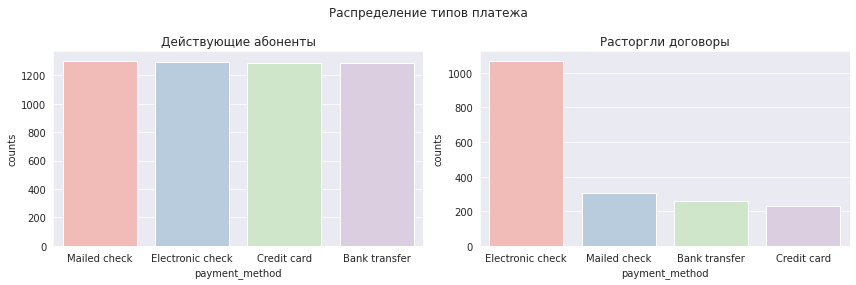

In [35]:
no_contract_pm['payment_method'] = no_contract_pm['payment_method'].replace({'Bank transfer (automatic)': 'Bank transfer',
                                                     'Credit card (automatic)': 'Credit card'})

yes_contract_pm['payment_method'] = yes_contract_pm['payment_method'].replace({'Bank transfer (automatic)': 'Bank transfer',
                                                     'Credit card (automatic)': 'Credit card'})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 4])
sns.barplot(x='payment_method', y='counts', data=yes_contract_pm, palette='Pastel1', ax=ax1)
ax1.set_title('Действующие абоненты')
sns.barplot(x='payment_method', y='counts', data=no_contract_pm, palette='Pastel1', ax=ax2)
ax2.set_title('Расторгли договоры')
plt.suptitle('Распределение типов платежа')
plt.tight_layout()
plt.show()

-  Действующие абоненты в равной степени предпочитают все типы платежа.  
-  Абоненты, которые расторгли договор по большей части (ок. 60 %) в качестве метода оплаты предпочитают электронный чек. Такие методы как  почтовый чек, банковский перевод и кредитная карта примерно одинаково популярны у остальной части этих плательщиков.
-  Вывод: признак 'payment_method' является значимым.

<b>monthly_charges</b>

Для исследования информации о расходах на услуги связи  по столбцу 'monthly_charges'построим гистограммы и боксплоты.

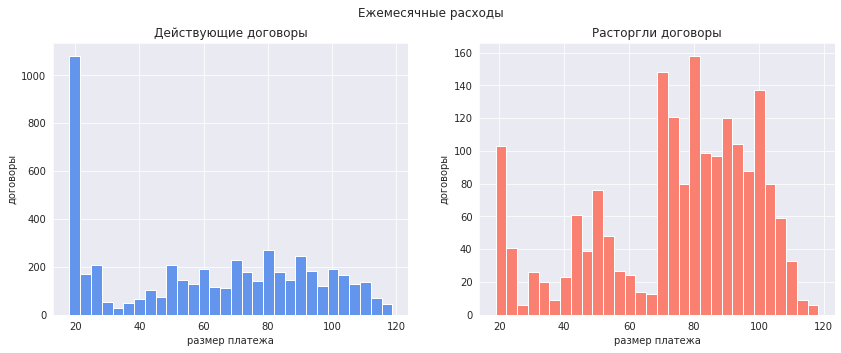

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].hist(yes_contract['monthly_charges'], bins=30, color='cornflowerblue')
axs[0].set_title('Действующие договоры')
axs[0].set_xlabel('размер платежа')
axs[0].set_ylabel('договоры')

axs[1].hist(no_contract['monthly_charges'], bins=30, color='salmon')
axs[1].set_title('Расторгли договоры')
axs[1].set_xlabel('размер платежа')
axs[1].set_ylabel('договоры')

plt.suptitle('Ежемесячные расходы')

plt.show()

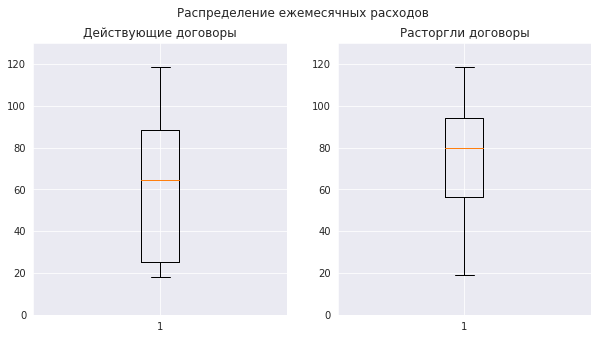

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_ylim(0, 130)
ax1.boxplot(yes_contract['monthly_charges'])
ax1.set_title('Действующие договоры')

ax2.set_ylim(0, 130)
ax2.boxplot(no_contract['monthly_charges'])
ax2.set_title('Расторгли договоры')

fig.suptitle('Распределение ежемесячных расходов')

plt.show()

К сожалению в представленных данных отсутствует информация как о тарифах на услуги связи, так и то, в каких единицах (валюта, единица измерения) показаны данные о ежемесячных и общих расходах на оплату услуг связи. назовем их условные единицы. Отсутствие таких данных может негативно сказаться на анализе факторов, влияющих на поведение клиентов. Но для построения модели машинного обучения данные (в том числе и о расходах на связь) масштабируются и отсутствие информации о единицах измерения влияния на качество модели не должно оказать.

-  Данные о ежмесячных расходах действующих клиентов «ТелеДома» свидетельствуют что у значительной доли абонентов расходы варьируются в пределах от 20 90 условных единиц. Примерно шестая часть каждый месяц платит по минимуму.
-  Нижний порог ежемесячной оплаты большей части абонентов, которые расторгли договоры, значительно выше и начинается около 60 и заканчивается около 100 условных единиц.
-   Вывод: признак 'monthly_charges' является значимым для построения модели машинного обучения.

<b>total_charges</b>

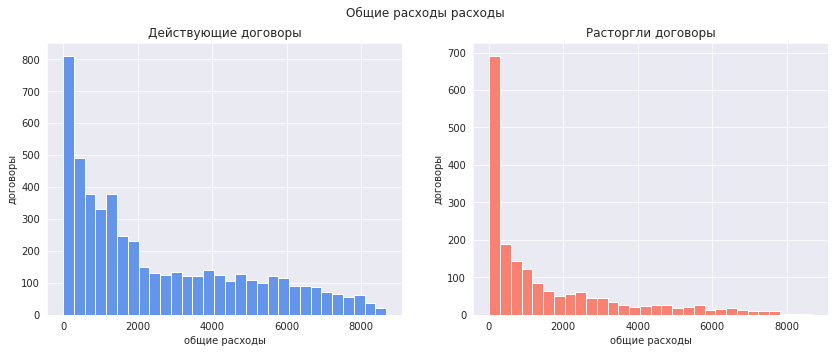

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].hist(yes_contract['total_charges'], bins=30, color='cornflowerblue')
axs[0].set_title('Действующие договоры')
axs[0].set_xlabel('общие расходы')
axs[0].set_ylabel('договоры')

axs[1].hist(no_contract['total_charges'], bins=30, color='salmon')
axs[1].set_title('Расторгли договоры')
axs[1].set_xlabel('общие расходы')
axs[1].set_ylabel('договоры')

plt.suptitle('Общие расходы расходы')

plt.show()

Распределение данных признака 'total_charges' говорит о том, что абоненты, которые расторгли договор, в общем заплатили меньше. Но это логично, потому что они перестали быть клиентами компании и, соответственно, перестали платить. По действующим абонентам также нельзя делать однозначные выводы об общих расходах из-за принудительности даты окончания договора. 

Вместе с тем, данный признак оставим для передаче для обучения моделей, т.к. возможно, как указывалось ранее, будущим моделям предсказаний удастся уловить правильную взаимосвязь между этим признаком и такими как тип оплаты, ежемесячные расходы и длительность договоров.

#### Изучим корреляцию количественных признаков

В наборе данных contract четыре количественных признака, включая бинарный целевой "target". С помощью метода corr() посмотрим на взаимозависимость этих данных (за исключением бинарного целевого) и построим матрицу корреляции.

,monthly_charges,total_charges,duration_contracts
monthly_charges,1.000000,0.756874,-0.014112
total_charges,0.756874,1.000000,-0.010011
duration_contracts,-0.014112,-0.010011,1.000000


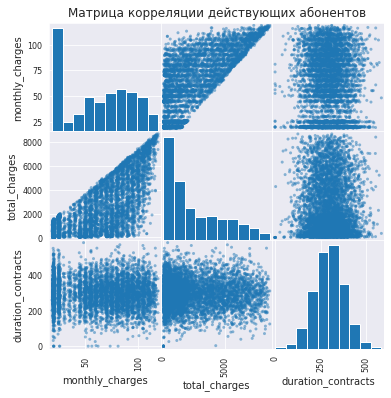

In [39]:
corr_yes_contr = yes_contract[['monthly_charges','total_charges','duration_contracts']]
ax = pd.plotting.scatter_matrix(corr_yes_contr,figsize=(6, 6))
ax = ax[0, 1].set_title("Матрица корреляции действующих абонентов")
corr_yes_contr.corr()

,monthly_charges,total_charges,duration_contracts
monthly_charges,1.000000,0.545772,-0.019146
total_charges,0.545772,1.000000,0.003542
duration_contracts,-0.019146,0.003542,1.000000


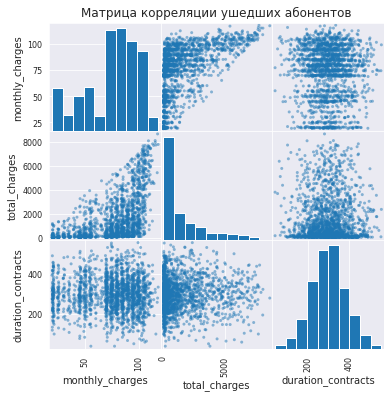

In [40]:
corr_no_contr = no_contract[['monthly_charges','total_charges','duration_contracts']]
ax = pd.plotting.scatter_matrix(corr_no_contr,figsize=(6, 6))
ax = ax[0, 1].set_title("Матрица корреляции ушедших абонентов")
corr_no_contr.corr()

Как по действующим абонентам, так и по тем, кто ушел от оператора усматривается ощутимая положительная корреляция между ежемесячными и общими расходами на связь. Между ежемесячными расходами и длительностью контрактов корреляция, можно сказать отсутствует - очень слабая отрицательная. По корреляции корреляции общих расходов и длительности контрактов данные у абонентов несколько разнятся - очень слабая отрицательная отмечается у действующих абонентов и очень слабая положительная - у тех, кто расторг договоры. Но к такой разнице стоит отнестись критически, поскольку для действующих абонентов у нас принудительный срок окончания договора.  

Таким образом мы определились с набором признаков датафрейма contract, которые мы передадим для построения модели машинного обучения. Сформируем его для объединения в общий датафрейм. 

In [41]:
contract_all = contract[['customer_id',  'type', 'paperless_billing','payment_method', 
                         'monthly_charges', 'target', 'total_charges', 'duration_contracts']] 
contract_all.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,target,total_charges,duration_contracts
0,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,0,0.00,0
1,3115-CZMZD,Two year,No,Mailed check,20.25,0,0.00,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,1,108.15,479
3,5709-LVOEQ,Two year,No,Mailed check,80.85,0,0.00,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,1,151.65,279


In [42]:
contract_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         7043 non-null   object 
 1   type                7043 non-null   object 
 2   paperless_billing   7043 non-null   object 
 3   payment_method      7043 non-null   object 
 4   monthly_charges     7043 non-null   float64
 5   target              7043 non-null   int64  
 6   total_charges       7043 non-null   float64
 7   duration_contracts  7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


Таблица <b>personal</b>

In [43]:
study(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Найдено пропусков:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Найдено дубликатов: 0


В таблице personal насчитывается 7043 объекта и 5 столбцов, 4 из которых представлены типом object, 1 - int64. Пропусков нет. Полные дубликаты отсутствуют. Наименования столбцов требуют приведения к общепринятому формату - нижнему регистру с разделением составных наименований нижней чертой.

Приводим к общепринятому формату наименования столбцов

In [44]:
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
personal.head(3)

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [45]:
# Проверяем наличие дубликатов по 'customer_id'

print('Количество дубликатов:', personal['customer_id'].duplicated().sum())

Количество дубликатов: 0


Для анализа зависимости признаков таблицы personal создадим два рабочих датафрейма - один по  действующим абонентам, второй по абонентам, которые расторгли договоры. Для объединения используем метод merge(), объединение проведем по полю 'customer_id'.

In [46]:
# объединяем с датафреймом действующих абонентов
yes_personal = personal.merge(yes_contract[['customer_id']], on = 'customer_id') 
# объединяем с датафреймом абонентов, расторгнувших договор
no_personal = personal.merge(no_contract[['customer_id']], on = 'customer_id')

Проверяем данные

In [47]:
yes_personal.info()
yes_personal.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5174 entries, 0 to 5173
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     5174 non-null   object
 1   gender          5174 non-null   object
 2   senior_citizen  5174 non-null   int64 
 3   partner         5174 non-null   object
 4   dependents      5174 non-null   object
dtypes: int64(1), object(4)
memory usage: 242.5+ KB


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,7795-CFOCW,Male,0,No,No


In [48]:
no_personal.info()
no_personal.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 0 to 1868
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     1869 non-null   object
 1   gender          1869 non-null   object
 2   senior_citizen  1869 non-null   int64 
 3   partner         1869 non-null   object
 4   dependents      1869 non-null   object
dtypes: int64(1), object(4)
memory usage: 87.6+ KB


,customer_id,gender,senior_citizen,partner,dependents
0,3668-QPYBK,Male,0,No,No
1,9237-HQITU,Female,0,No,No
2,9305-CDSKC,Female,0,No,No


Изучаем распределение абонентов в зависимости от пола. Для этого сгруппируем значения столбцов <b>'gender'</b> в обоих датафреймах и визуализируем информацию.

In [49]:
# группируем данные
no_personal['gender'] = no_personal['gender'].replace({'Male': 'мужчины',
                                                     'Female': 'женщины'})

yes_personal['gender'] = yes_personal['gender'].replace({'Male': 'мужчины',
                                                     'Female': 'женщины'})

gender = pd.concat(
                  [yes_personal['gender'].value_counts().to_frame(),
                   no_personal['gender'].value_counts().to_frame(),
                   ], axis=1)

gender.columns = ['yes_contract', 'no_contract']
gender

,yes_contract,no_contract
мужчины,2625,930
женщины,2549,939


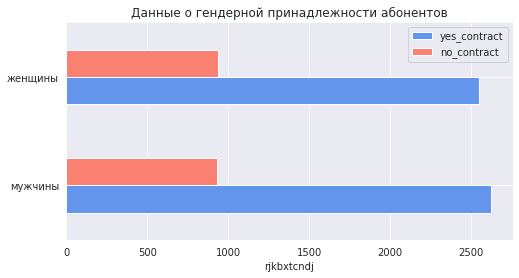

In [50]:
gender.plot(kind='barh', color = ['cornflowerblue','salmon'], figsize=(8, 4))
plt.xlabel('rjkbxtcndj')
ax =plt.title('Данные о гендерной принадлежности абонентов')

Распределение гендерной принадлежности действующих абонентов и тех, кто расторг договор можно считать одинаковым: почти поровну мужчин и женщин в обеих выборках. Значит признак не является значимым. 

Смотрим какой процент составляют пенсионеры. Сгруппируем данные по столбцу <b>senior_citizen</b> и визуализируем их.

In [51]:
# группируем данные
senior_citizen = pd.concat(
                  [yes_personal['senior_citizen'].value_counts().to_frame(),
                   no_personal['senior_citizen'].value_counts().to_frame(),
                   ], axis=1)

senior_citizen.columns = ['yes_contract', 'no_contract']
senior_citizen

,yes_contract,no_contract
0,4508,1393
1,666,476


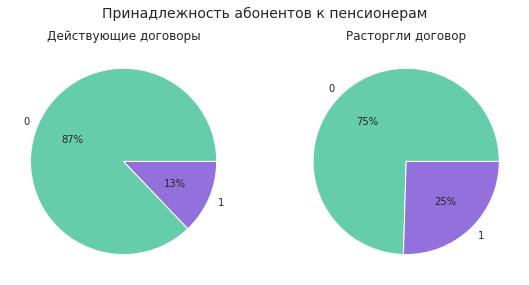

In [52]:
s = yes_personal.groupby('senior_citizen').size()
ss = no_personal.groupby('senior_citizen').size()

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
s.plot(kind='pie', colors = ['mediumaquamarine', 'mediumpurple'],autopct='%1.0f%%')
plt.title("Действующие договоры")
plt.ylabel("")

plt.subplot(1, 2, 2)
ss.plot(kind='pie', colors = ['mediumaquamarine', 'mediumpurple'],autopct='%1.0f%%')
plt.title("Расторгли договор")
plt.ylabel("")

plt.suptitle("Принадлежность абонентов к пенсионерам", fontsize=14)
plt.tight_layout()

plt.show()

Данные в столбце senior_citizen классифицированы. Логично предположить, что абоненты, отнесенные к классу 1 являются пенсионерами, к классу 0 - нет. 
-  Доля пенсионеров среди действующих абонентов составляет 13 %.
-  Доля пенсионеров среди тех, кто расторг договор - 25 %.
Очевидно, что такой признак, как принадлежность к пенсионерам, является значимым для предсказания факта расторжения договора связи.

Исследуем данные о семейном положении абрнентов по столбцу <b>partner</b> 

In [53]:
# группируем данные
no_personal['partner'] = no_personal['partner'].replace({'Yes': 'есть супруг',
                                                     'No': 'нет супруга'})

yes_personal['partner'] = yes_personal['partner'].replace({'Yes': 'есть супруг',
                                                     'No': 'нет супруга'})

partner = pd.concat(
                  [yes_personal['partner'].value_counts().to_frame(),
                   no_personal['partner'].value_counts().to_frame(),
                   ], axis=1)

partner.columns = ['yes_contract', 'no_contract']

,yes_contract,no_contract
есть супруг,2733,669
нет супруга,2441,1200


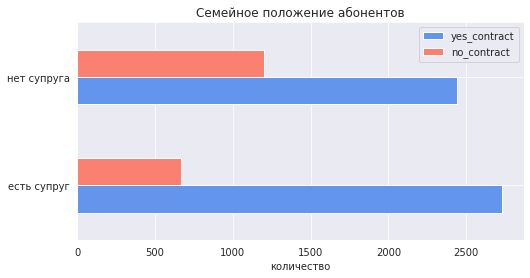

In [54]:
partner.plot(kind='barh', color = ['cornflowerblue','salmon'], figsize=(8, 4)) # bar
plt.xlabel('количество')
ax =plt.title('Семейное положение абонентов')
partner

Данные по столбцу 'partner' классифицированы. К классу 1 отнесены абоненты, имеющие супруга, к классу 0 - не имеющие. Признак семейного положения является значимым.
-  Число действующих абонентов, имеющих супругов, незначительно превышает тех, у кого их нет.
-  В числе клиентов, расторгнувших контракт, тех, у кого есть супруг, значительно (почти в два раза) меньше тех, кто их не имеет.

Исследуем данные о наличии детей у абрнентов по столбцу <b>dependents</b> 

In [55]:
# группируем данные
no_personal['dependents'] = no_personal['dependents'].replace({'No': 'нет детей',
                                                     'Yes': 'есть дети'})

yes_personal['dependents'] = yes_personal['dependents'].replace({'No': 'нет детей',
                                                     'Yes': 'есть дети'})


dependents = pd.concat(
                  [yes_personal['dependents'].value_counts().to_frame(),
                   no_personal['dependents'].value_counts().to_frame(),
                   ], axis=1)

dependents.columns = ['yes_contract', 'no_contract']

,yes_contract,no_contract
нет детей,3390,1543
есть дети,1784,326


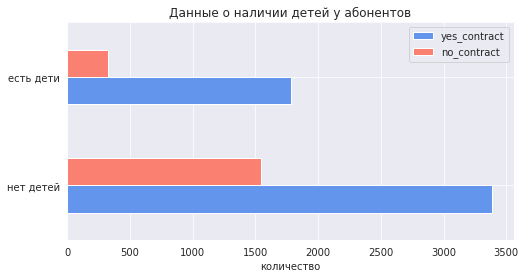

In [56]:
dependents.plot(kind='barh', color = ['cornflowerblue','salmon'], figsize=(8, 4))
plt.xlabel('количество')
ax =plt.title('Данные о наличии детей у абонентов')
dependents

Данные по столбцу 'dependents' классифицированы. К классу 1 отнесены абоненты, имеющие детей, к классу 0 - не имеющие. Признак наличия/отсутствия детей является значимым.

-  Число действующих абонентов, не имеющих детей, примерно в два раза больше тех, у кого они есть.
-  В числе клиентов, расторгнувших контракт, тех, у кого нет детей почти в пять раз больше абонентов с детьми.

Таким образом мы определились с набором признаков датафрейма personal, которые мы передадим для построения модели машинного обучения. Сформируем его для объединения в общий датафрейм.

In [57]:
personal_all = personal[['customer_id', 'senior_citizen', 'partner', 'dependents']]
personal_all.head()

,customer_id,senior_citizen,partner,dependents
0,7590-VHVEG,0,Yes,No
1,5575-GNVDE,0,No,No
2,3668-QPYBK,0,No,No
3,7795-CFOCW,0,No,No
4,9237-HQITU,0,No,No


In [58]:
personal_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   senior_citizen  7043 non-null   int64 
 2   partner         7043 non-null   object
 3   dependents      7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 220.2+ KB


таблица <b>internet</b>

In [59]:
study(internet)

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB

Найдено пропусков:
c1    0
c2    0
c3    0
c4    0
c5    0
c6    0
c7    0
c8    0
dtype: int64

Найдено дубликатов: 0


В таблице internet насчитывается 5518 объектов и 8 столбцов, представленных типом object. Пропусков нет. Полные дубликаты отсутствуют. Столбцы пронумерованы, соответствующие им наименования заданы в строке с индексом 0, и требуют вынесения в "шапку" датафрейма и приведения к общепринятому формату - нижнему регистру с разделением составных названий нижней чертой.

В качестве наименований столбцов передаем данные первой строки, которую по индексу удаляем из датафрейма

In [60]:
internet.columns= ['customer_id','internet_service','online_security','online_backup','device_protection','tech_support',
                   'streaming_tv','streaming_movies']
internet = internet.drop(internet.index[0])
internet.head(3)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [61]:
# Проверяем наличие дубликатов по столбцу customer_id
print('Количество дубликатов:', internet['customer_id'].duplicated().sum())

Количество дубликатов: 0


Очевидно, что в датафрейме internet количество объектов меньше чем в датафрейме contract. Это может означать что не все абоненты «ТелеДома» подключили себе интернет-услуги через данную компанию. Найдем их количество.

In [62]:
print('Количество абонентов, не пользующихся услугами интернета:', len(contract) - len(internet))

Количество абонентов, не пользующихся услугами интернета: 1526


Для анализа зависимости признаков таблицы internet создадим два рабочих датафрейма - один по действующим абонентам, второй по абонентам, которые расторгли договоры. Для объединения используем метод merge(), объединение проведем по полю 'customer_id' и параметром how по умолчанию (inner). 

In [63]:
# объединяем с датафреймом действующих абонентов
yes_internet = internet.merge(yes_contract[['customer_id']], on = 'customer_id')

# объединяем с датафреймом абонентов, расторгнувших договор
no_internet = internet.merge(no_contract[['customer_id']], on = 'customer_id')

Проверяем данные

In [64]:
yes_internet.info()
yes_internet.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3761 entries, 0 to 3760
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        3761 non-null   object
 1   internet_service   3761 non-null   object
 2   online_security    3761 non-null   object
 3   online_backup      3761 non-null   object
 4   device_protection  3761 non-null   object
 5   tech_support       3761 non-null   object
 6   streaming_tv       3761 non-null   object
 7   streaming_movies   3761 non-null   object
dtypes: object(8)
memory usage: 264.4+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [65]:
no_internet.info()
no_internet.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1756 entries, 0 to 1755
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        1756 non-null   object
 1   internet_service   1756 non-null   object
 2   online_security    1756 non-null   object
 3   online_backup      1756 non-null   object
 4   device_protection  1756 non-null   object
 5   tech_support       1756 non-null   object
 6   streaming_tv       1756 non-null   object
 7   streaming_movies   1756 non-null   object
dtypes: object(8)
memory usage: 123.5+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
1,9237-HQITU,Fiber optic,No,No,No,No,No,No
2,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes


Изучим распределение данных о типе подключения к интернету.

In [66]:
# группируем данные
internet_service = pd.concat(
                  [yes_internet['internet_service'].value_counts().to_frame(),
                   no_internet['internet_service'].value_counts().to_frame(),
                   ], axis=1)

internet_service.columns = ['yes_contract', 'no_contract']
internet_service

,yes_contract,no_contract
DSL,1962,459
Fiber optic,1799,1297


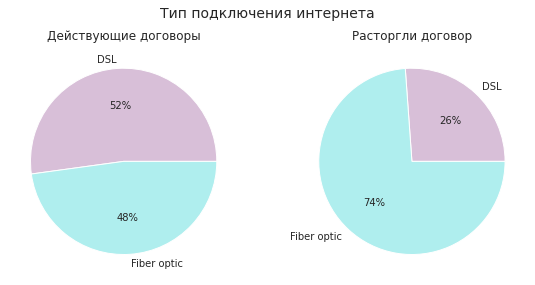

In [67]:
i = yes_internet.groupby('internet_service').size()
ii = no_internet.groupby('internet_service').size()

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
i.plot(kind='pie', colors = ['thistle', 'paleturquoise'],autopct='%1.0f%%')
plt.title("Действующие договоры")
plt.ylabel("")

plt.subplot(1, 2, 2)
ii.plot(kind='pie', colors = ['thistle', 'paleturquoise'],autopct='%1.0f%%')
plt.title("Расторгли договор")
plt.ylabel("")

plt.suptitle("Тип подключения интернета", fontsize=14)
plt.tight_layout()

plt.show()

Тип подключения к интернету можно считать значимым признаком.
-  Абоненты с действующими договорами почти в равной степени предпочитают цифровую связь и через телефонную линию, чего нельзя сказать о тех, кто расторг договор с компанией. 
-  Три четверти клиентов, которые расторгли договоры, имели цифровую связь. 

Для изучения активности пользования абонентами услуг интернета визуализируем эту информацию, для чего создадим датафрейм, предварительно сгруппировав данные по значениям столбцов видов услуг.

In [68]:
# группируем данные
yes_in_services = pd.concat(
                             [yes_internet['online_security'].value_counts().to_frame(),
                             yes_internet['online_backup'].value_counts().to_frame(),
                             yes_internet['device_protection'].value_counts().to_frame(),
                             yes_internet['tech_support'].value_counts().to_frame(), 
                             yes_internet['streaming_tv'].value_counts().to_frame(),
                             yes_internet['streaming_movies'].value_counts().to_frame()], 
    axis=1)

yes_in_services= yes_in_services.transpose()
yes_in_services

,No,Yes
online_security,2037,1724
online_backup,1855,1906
device_protection,1884,1877
tech_support,2027,1734
streaming_tv,1868,1893
streaming_movies,1847,1914


In [69]:
no_in_services = pd.concat(
                             [no_internet['online_security'].value_counts().to_frame(),
                             no_internet['online_backup'].value_counts().to_frame(),
                             no_internet['device_protection'].value_counts().to_frame(),
                             no_internet['tech_support'].value_counts().to_frame(), 
                             no_internet['streaming_tv'].value_counts().to_frame(),
                             no_internet['streaming_movies'].value_counts().to_frame()], 
    axis=1)

no_in_services= no_in_services.transpose()
no_in_services

,No,Yes
online_security,1461,295
online_backup,1233,523
device_protection,1211,545
tech_support,1446,310
streaming_tv,942,814
streaming_movies,938,818


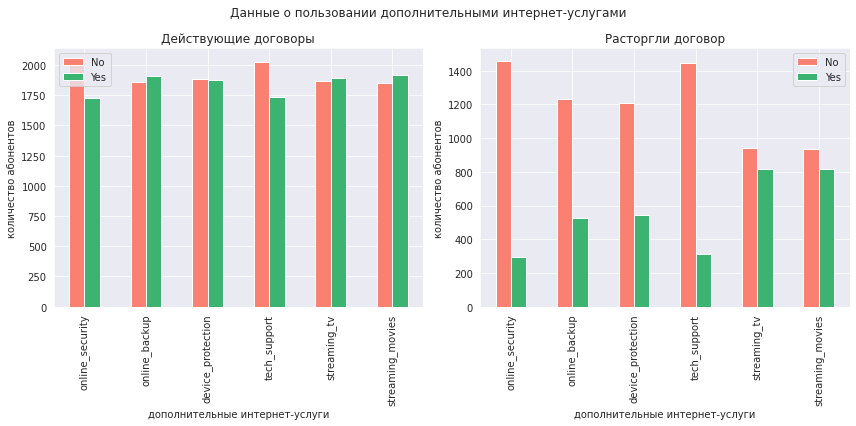

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

yes_in_services.plot(kind='bar', color=['salmon', 'mediumseagreen'], ax=axes[0])
axes[0].set_ylabel('количество абонентов')
axes[0].set_xlabel('дополнительные интернет-услуги')
axes[0].set_title('Действующие договоры')

no_in_services.plot(kind='bar', color=['salmon', 'mediumseagreen'], ax=axes[1])
axes[1].set_ylabel('количество абонентов')
axes[1].set_xlabel('дополнительные интернет-услуги')
axes[1].set_title('Расторгли договор')

plt.suptitle('Данные о пользовании дополнительными интернет-услугами')
plt.tight_layout()
plt.show()


Данные столбцов о пользовании дополнительными интернет-услугами классифицированы, где логично предположить что к классу 1 отнесены те, ктопользуется этими услугами, классу  0 - нет.
-  Очевидно, что абоненты, которые продолжают оставаться клиентами «ТелеДома», активно пользуются дополнительными интернет-услугами. Особенно популярны облачное хранилище файлов для резервного копирования данных, антивирус, стриминговое телевидение и каталог фильмов, где число пользователей превосходит (или равно), тех, кто ими не пользуется.
-  Иная картина отмечается по клиентам, расторгнувшим договор. По всем видам дополнительных интернет-услуг число тех, кто их не имеет, превосходит количество подключенных к ним.

Однозначно, все признаки пользования дополнительными интернет-услугами являются значимыми.

Таблица <b>phone</b>

In [71]:
study(phone)

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Найдено пропусков:
c1    0
c2    0
dtype: int64

Найдено дубликатов: 0


-  В таблице phone насчитывается 6362 объекта, представленных типом object. Пропусков нет. Полные дубликаты отсутствуют. Столбцы пронумерованы, соответствующие им наименования заданы в строке с индексом 0, и требуют вынесения в "шапку" датафрейма и приведения к общепринятому формату - нижнему регистру с разделением составных названий нижней чертой.

-  Таблица telecom.phone должна содержать информацию об услугах телефонии, однако она представлена только данными о подключении абонента к нескольким линиям одновременно, что явно недостаточно. Для полноты анализа возможно было бы дополнить таблицу данными о виде стационарной связи: местнaя, междугородняя, междунaроднaя, которая отличается тарифами, количеством использования, а также характеристиками абонентов, которые предпочитают платить за тот или иной вид.

В  качестве наименований столбцов передаем данные первой строки, которую по индексу удаляем из датафреймов.

In [72]:
phone.columns = ['customer_id','multiple_lines']
phone =phone.drop(phone.index[0])
phone.head(3)

,customer_id,multiple_lines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No


In [73]:
# Проверяем наличие дубликатов по 'customer_id'
print('Количество дубликатов:', phone['customer_id'].duplicated().sum())

Количество дубликатов: 0


В датафрейме phone количество объектов меньше чем в датафрейме contract. Это, как и в таблице internet, также может означать что не все абоненты «ТелеДома» пользуются стационарной телефонной связью данной компании. Узнаем их количество.

In [74]:
print('Количество абонентов, не пользующихся стационарной телефонной связью:', len(contract) - len(phone))

Количество абонентов, не пользующихся стационарной телефонной связью: 682


Для анализа зависимости признака таблицы phone создадим два рабочих датафрейма - один по действующим абонентам, второй по абонентам, которые расторгли договоры. 

In [75]:
# объединяем с датафреймом действующих абонентов
yes_phone = phone.merge(yes_contract[['customer_id']], on = 'customer_id')

# объединяем с датафреймом абонентов, расторгнувших договор
no_phone = phone.merge(no_contract[['customer_id']], on = 'customer_id')

Проверяем данные

In [76]:
yes_phone.info()
yes_phone.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4662 entries, 0 to 4661
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     4662 non-null   object
 1   multiple_lines  4662 non-null   object
dtypes: object(2)
memory usage: 109.3+ KB


,customer_id,multiple_lines
0,5575-GNVDE,No
1,1452-KIOVK,Yes
2,6388-TABGU,No


In [77]:
no_phone.info()
no_phone.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1699 entries, 0 to 1698
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     1699 non-null   object
 1   multiple_lines  1699 non-null   object
dtypes: object(2)
memory usage: 39.8+ KB


,customer_id,multiple_lines
0,3668-QPYBK,No
1,9237-HQITU,No
2,9305-CDSKC,Yes


Для визуализации данных сначала их сгруппируем построим диаграмму

In [78]:
# группируем данные
yes_phone['multiple_lines'] = yes_phone['multiple_lines'].replace({'No': 'не подключены',
                                                     'Yes': 'подключены'})

no_phone['multiple_lines'] = no_phone['multiple_lines'].replace({'No': 'не подключены',
                                                     'Yes': 'подключены'})
multiple_lines = pd.concat(
                  [yes_phone['multiple_lines'].value_counts().to_frame(),
                   no_phone['multiple_lines'].value_counts().to_frame(),
                   ], axis=1)

multiple_lines.columns = ['yes_contract', 'no_contract']
multiple_lines

,yes_contract,no_contract
не подключены,2541,849
подключены,2121,850


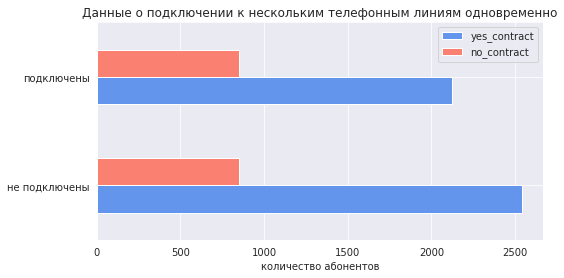

In [79]:
# строим диаграмму

multiple_lines.plot(kind='barh', color=['cornflowerblue','salmon'], figsize=(8, 4))
plt.xlabel('количество абонентов')
plt.title('Данные о подключении к нескольким телефонным линиям одновременно')
plt.show()

Признак  подключения к нескольким телефонным линиям по разному распределился среди абонентов.
-  Данные о подключении к нескольким телефонным линиям (или отсутствии такого подключения) по абонентам, которые расторгли контракт, практически одинаковы.
- Данные по действующим абонентам распределились несколько иначе: не имеющих подключения примерно на 20% больше тех, кто его имеет.

Признак оставляем.

 <b> Вывод:</b> В распоряжение предоставлено 4 набора данных с информацией о договорах, интернет-услугах, услугах телефонии, персональные данные клиентов. Мы изучили предоставленный набор данных, провели предварительную обработку.
    
Во всех таблицах привели наименования столбцов к общепринятому формату, в таблице contract типы данных столбцов 'begin_date' и 'end_date' изменены на datetime64, в столбце 'total_charges' пропуски заменены нулевыми значениями, сгенерированы новый признак 'duration_contracts' с данными о длительности договоров (в днях) и целевая переменная 'target', где 1 - абонент ушел от оператора связи, 0 - продолжает оставаться клиентом компании. Соотношение классов в целевом признаке 1/3, где 27 % данных принадлежат к положительному классу (1 - клиент расторг договор) и 73 % - к отрицательному (0 - клиент остается с оператором связи).
    
Также по этой таблице провели корреляционный анализ количественных небинарных признаков (по другим таблицам такие данные отсутствуют). Установили ощутимую положительную корреляцию между типом платежа и общей суммой. По иным признакам корреляция практически отсутствует. В результате исследования соотношения ушедших и оставшихся клиентов для каждого признака определились с набором признаков для передачи для обучения. 
    
Кроме того,  на основании исследования можно выделить характеристики клиента, склонного к расторжению договора.    
Эти абоненты предпочитают ежемесячный тип платежа, но при этом платят больше, в основном от 60 до 100 условных единиц в месяц. Реже используют электронные расчетные листы. Решение о смене оператора связи принимают, как правило по истечении примерно 8-11 месяцев.Среди этих клиентов  чаще встречаются одинокие (без супругов и детей) и пенсионеры. У таких клиентов чаще проведена цифровая связь, но они не пользуются в полной мере ее возможностями - гораздо реже подключают дополнительные интернет-услуги. У нас нет данных о тарифах на связь, но можно предположить что клиенты, слонные к уходу, как раз и переплачивают больше за потенциальную возможность пользоваться услугами и фактическое не использование их.
    
Бизнес-задачей оператора связи «ТелеДом» является удержание абонентов, потенциально склонных к расторжению договора, за счет предложений специальных условий. Наша задача состоит в построении модели машинного обучения по предсказанию  ухода клиента на основе набора данных об абонентах, имеющегося в распоряжении заказчика, получении предсказаний и оценки их метриками бинарной классификации.    

## Объединение датафреймов и подготовка признаков

С учетом выводов о необходимости признаков для построения модели машинного обучения объединим сформированные наборы данных (contract_all и personal_all), а также те, что мы оставили в полном объеме (internet и phone) в общий датафрейм. Объединение проведем методом merge() по признаку customer_id. Там, где у нас наборы данных не совпадают, параметр  how зададим таким образом, чтоб вошли все данные из большего датафрейма. Пропущенные значения заменим. 

In [80]:
# объединяем датафреймы

df_cp = contract_all.merge(personal_all, on = 'customer_id')
df_cpi = df_cp.merge(internet, on = 'customer_id', how = 'left')
all_df = df_cpi.merge(phone, on = 'customer_id', how = 'left')

In [81]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         7043 non-null   object 
 1   type                7043 non-null   object 
 2   paperless_billing   7043 non-null   object 
 3   payment_method      7043 non-null   object 
 4   monthly_charges     7043 non-null   float64
 5   target              7043 non-null   int64  
 6   total_charges       7043 non-null   float64
 7   duration_contracts  7043 non-null   int64  
 8   senior_citizen      7043 non-null   int64  
 9   partner             7043 non-null   object 
 10  dependents          7043 non-null   object 
 11  internet_service    5517 non-null   object 
 12  online_security     5517 non-null   object 
 13  online_backup       5517 non-null   object 
 14  device_protection   5517 non-null   object 
 15  tech_support        5517 non-null   object 
 16  stream

В объединенном датафрейме по всем признакам из данных  internet и phone имеются пропущенные значения. Как мы пришли к выводу при изучении этих таблиц, это может означать, что абоненты не подключены к интернету или телефону. Все эти признаки содержат категориальные значения 'Yes' или 'No' (есть услуги или нет). Если отсутствует подключение, заменим его на значение 'No'.

In [82]:
all_df = all_df.fillna('No')
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         7043 non-null   object 
 1   type                7043 non-null   object 
 2   paperless_billing   7043 non-null   object 
 3   payment_method      7043 non-null   object 
 4   monthly_charges     7043 non-null   float64
 5   target              7043 non-null   int64  
 6   total_charges       7043 non-null   float64
 7   duration_contracts  7043 non-null   int64  
 8   senior_citizen      7043 non-null   int64  
 9   partner             7043 non-null   object 
 10  dependents          7043 non-null   object 
 11  internet_service    7043 non-null   object 
 12  online_security     7043 non-null   object 
 13  online_backup       7043 non-null   object 
 14  device_protection   7043 non-null   object 
 15  tech_support        7043 non-null   object 
 16  stream

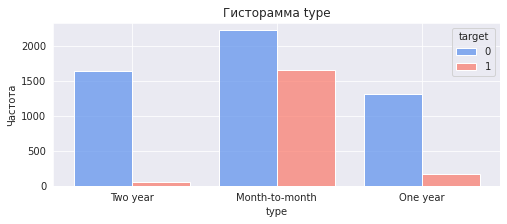

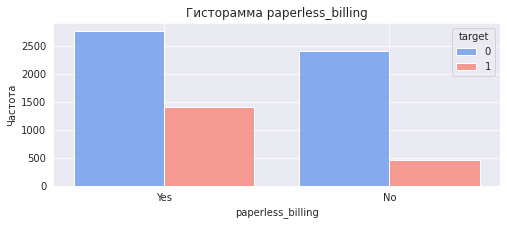

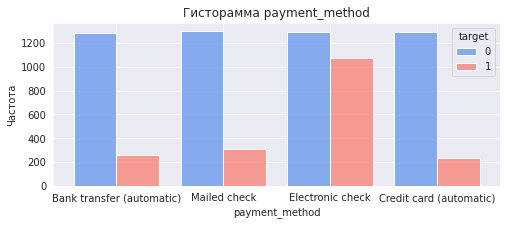

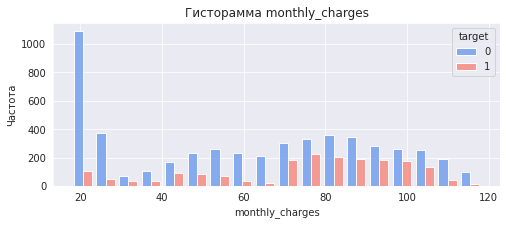

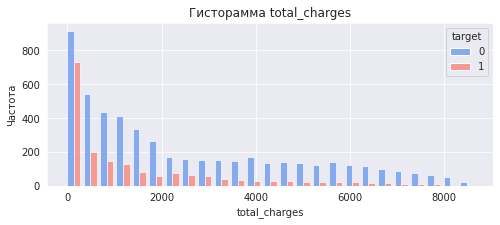

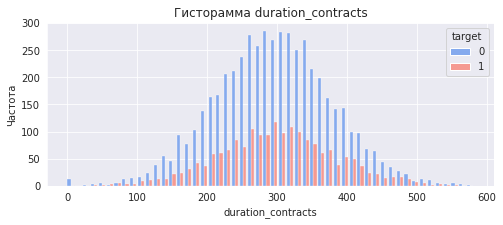

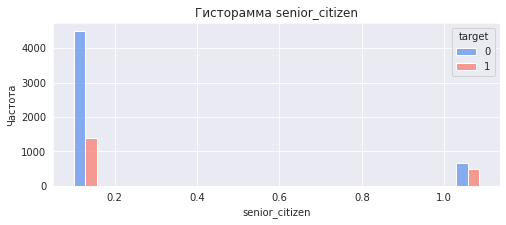

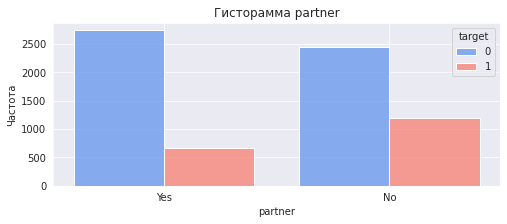

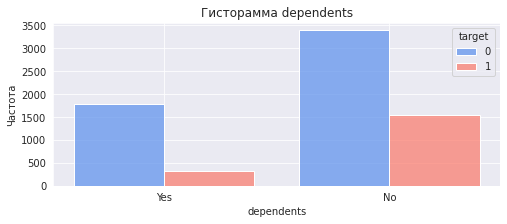

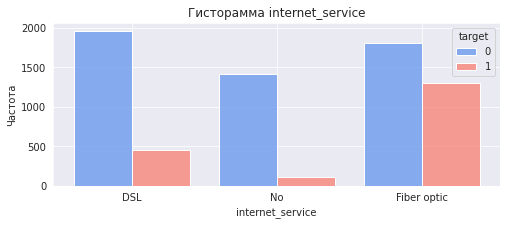

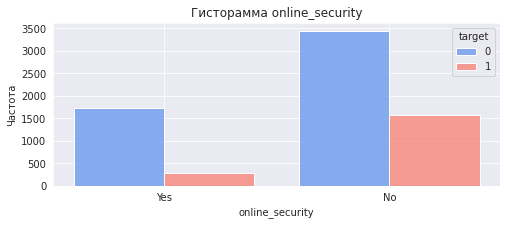

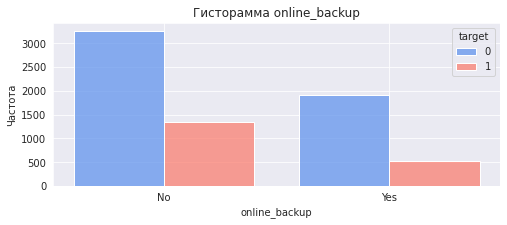

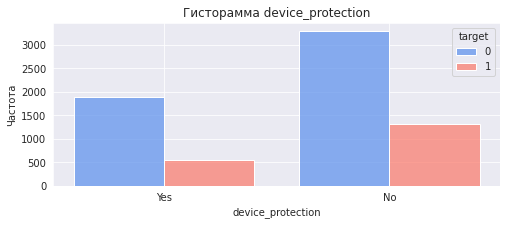

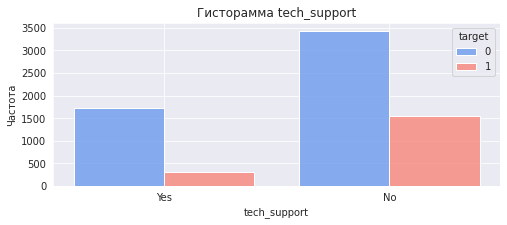

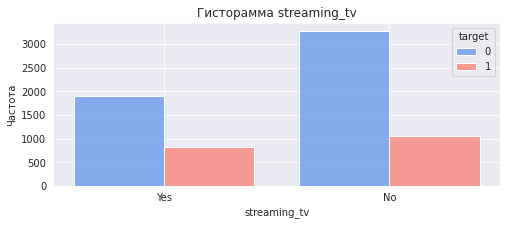

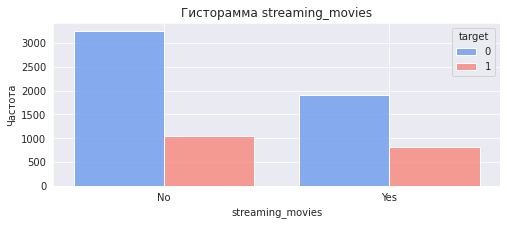

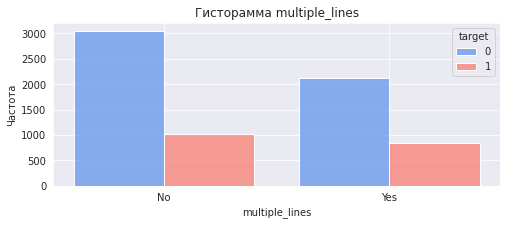

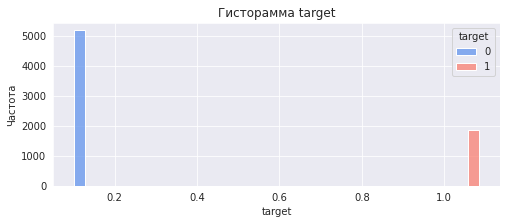

In [83]:
for i in ['type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'duration_contracts', 
          'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 
          'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'target']:
    plt.figure(figsize=(8,3))
    sns.histplot(data=all_df, x=i, hue='target', multiple="dodge", shrink=.8, palette=['cornflowerblue', 'salmon'])
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show()


Распределение признаков на объединенном датафрейме, даже с учетом замены пропущенных значений из таблиц internet и phone, соответствует распределению, установленному нами при первичном исследовании таблиц.  

In [84]:
phik_overview = all_df.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'duration_contracts', 'senior_citizen'])
phik_overview.round(2)
print('Подготовили матрицу корреляции Phik')

Подготовили матрицу корреляции Phik


In [85]:
phik_overview

,customer_id,type,paperless_billing,payment_method,monthly_charges,target,total_charges,duration_contracts,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
type,1.0,1.000000,0.106860,0.277462,0.388444,0.251639,0.505826,0.037860,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498
paperless_billing,1.0,0.106860,1.000000,0.370495,0.467812,0.295754,0.207127,0.050069,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972
payment_method,1.0,0.277462,0.370495,1.000000,0.399526,0.449125,0.350566,0.000868,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313
monthly_charges,1.0,0.388444,0.467812,0.399526,1.000000,0.360050,0.762839,0.015962,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883
target,1.0,0.251639,0.295754,0.449125,0.360050,1.000000,0.278498,0.034597,0.233432,0.232930,0.253936,0.196202,0.264580,0.126973,0.101516,0.254615,0.096865,0.093923,0.059581
total_charges,1.0,0.505826,0.207127,0.350566,0.762839,0.278498,1.000000,0.017197,0.149384,0.424467,0.119077,0.508222,0.545067,0.653989,0.671714,0.566062,0.660753,0.666609,0.606117
duration_contracts,1.0,0.037860,0.050069,0.000868,0.015962,0.034597,0.017197,1.000000,0.034522,0.016432,0.035546,0.030204,0.000000,0.032195,0.022743,0.000000,0.048799,0.053546,0.000000
senior_citizen,1.0,0.086231,0.242133,0.292725,0.304985,0.233432,0.149384,0.034522,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313
partner,1.0,0.179736,0.013218,0.243008,0.203545,0.232930,0.424467,0.016432,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101


In [86]:
# функция для тепловой карты матрицы корреляции 

def violentplot(df, column, target):
    plt.figure(figsize = (8, 5))
    sns.violinplot(
        x = target,
        y = column,
        all_df = df,
        kind = "violin",
        split = True,
        palette = "coolwarm"
    )
    plt.show()

    if df[column].nunique() <= 25:
        plt.figure(figsize = (12, 12))
        sns.histplot(data=df,
                     x=column,
                     binwidth=1,
                     hue=target)
        plt.show()

    print()
    print('Корреляция Phik:', np.round(phik_overview.loc[column]['target'], 2))
    print('-----------------------------------------------------------------------------------------------')
    print()

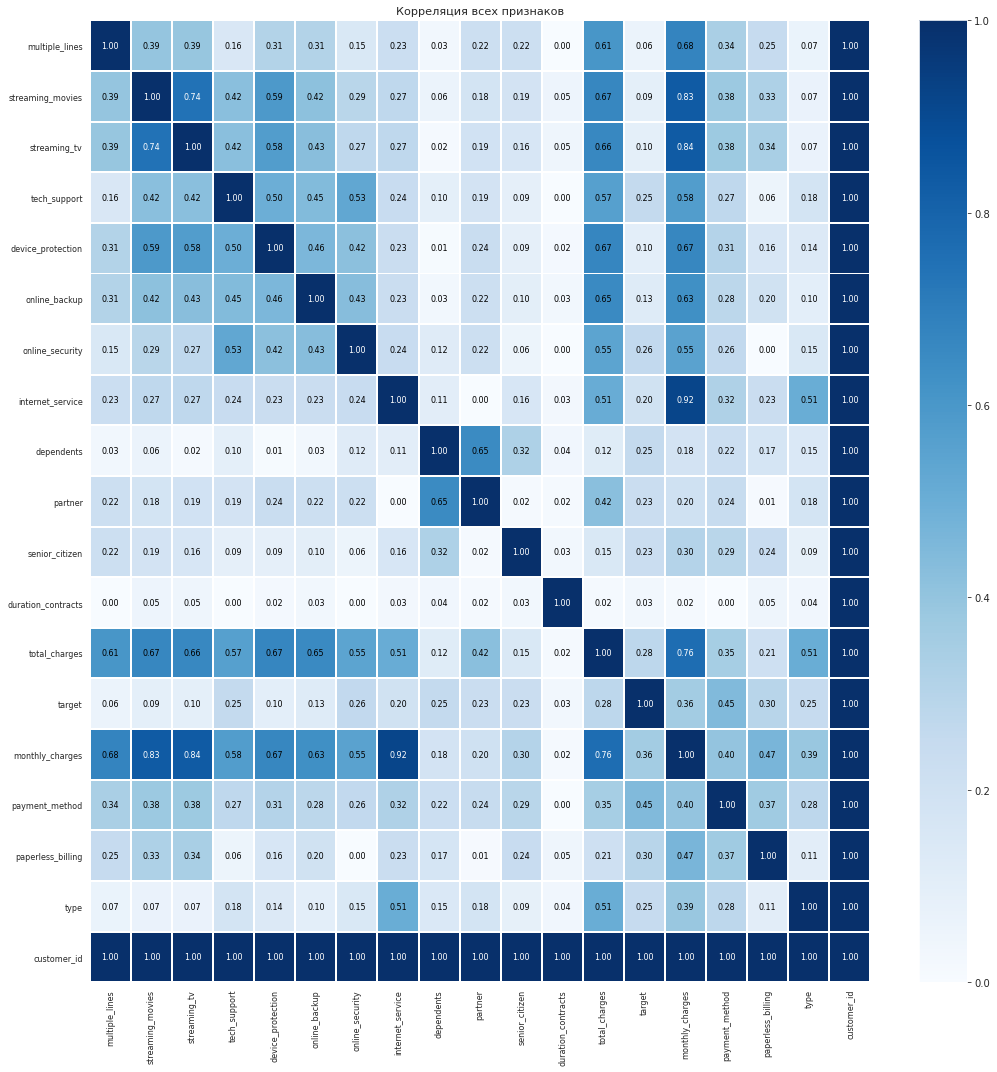

In [87]:
# выводим тепловую карту корреляции

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title = 'Корреляция всех признаков',
                        fontsize_factor=0.8, 
                        figsize=(15, 15))
plt.tight_layout()
plt.show()

Мультиколинеарности целевого признака с остальными не отмечается. Самая высокая корреляция у target с payment_method (0.45) и 
monthly_charges (0.36). 

Вообще monthly_charges довольно сильно коррелирует почти со всеми признаками, особенно теми, что связаны с интернет-услугами.  Исключениесоставляют признаки, связанные с семейным положением, пенсионеры и duration_contracts.

Сгенерированный нами новый признак duration_contracts имеет довольно низкую корреляцию с любым другим признаком (не более 0.05)

Наиболее сильная корреляция имеется у таких пар признаков как  streaming_movies-streaming_tv (0.74), streaming_movies-monthly_charges (0.84), streaming_tv -monthly_charges (0.84), streaming_movies и streaming_tv с total_charges (0.67), что вполне логично. Также логична высокая корреляция между partner и dependents (0.65)

Удаляем столбец 'customer_id' как неинформативный признак и еще раз проверяем пропуски

In [88]:
all_df = all_df.drop(columns='customer_id')

all_df.info()
all_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                7043 non-null   object 
 1   paperless_billing   7043 non-null   object 
 2   payment_method      7043 non-null   object 
 3   monthly_charges     7043 non-null   float64
 4   target              7043 non-null   int64  
 5   total_charges       7043 non-null   float64
 6   duration_contracts  7043 non-null   int64  
 7   senior_citizen      7043 non-null   int64  
 8   partner             7043 non-null   object 
 9   dependents          7043 non-null   object 
 10  internet_service    7043 non-null   object 
 11  online_security     7043 non-null   object 
 12  online_backup       7043 non-null   object 
 13  device_protection   7043 non-null   object 
 14  tech_support        7043 non-null   object 
 15  streaming_tv        7043 non-null   object 
 16  stream

type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
target                0
total_charges         0
duration_contracts    0
senior_citizen        0
partner               0
dependents            0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
multiple_lines        0
dtype: int64

Выделяем признаки и целевой признак

In [89]:
features=all_df.drop('target',axis=1) # признаки
target =all_df['target'] # целевой признак
display(features.head())
print(target.head())

,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_contracts,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Two year,Yes,Bank transfer (automatic),52.55,0.00,0,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
1,Two year,No,Mailed check,20.25,0.00,0,0,No,Yes,No,No,No,No,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,108.15,479,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,Two year,No,Mailed check,80.85,0.00,0,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,Month-to-month,Yes,Electronic check,70.70,151.65,279,0,No,No,Fiber optic,No,No,No,No,No,No,No


0    0
1    0
2    1
3    0
4    1
Name: target, dtype: int64


Делим данные на учебную и тестовую выборки в соотношении test_size = 0.25

In [90]:


train_features, test_features, train_target, test_target = train_test_split(features, target, 
                                                    train_size=0.75,  
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True)

In [91]:
print('Размеры выборок:')
print('train_features',train_features.shape)
print('test_features', test_features.shape)
print('train_target', train_target.shape)
print('test_target', test_target.shape)

Размеры выборок:
train_features (5282, 17)
test_features (1761, 17)
train_target (5282,)
test_target (1761,)


 <b> Вывод:</b> на основе выбранных признаков мы сформировали единый датафрейм. Таблицы internet и phone оставлены в полном объеме. Из таблицы contract исключены признаки,содержащие даты, из таблицы personal - 'gender'. Все наборы данных объединены по признаку 'customer_id', который впоследствии удален как неинформативный. Отсутствующие значения в объединенном датафрейме по всем признакам из данных internet и phone заменены на категориальное значение, указывающие на отсутствие соответствующих услуг.    
    
Представленные наборы данных нельзя назвать исчерпывающими. В таблице о договорах отсутствует информация как о тарифах на услуги связи, так и то, в каких единицах (валюта, единица измерения) показаны расходы. Информация об услугах телефонии не представлена  данными о виде стационарной связи (местнaя, междугородняя, междунaроднaя), которая отличается тарифами, количеством использования, а также характеристиками абонентов, которые предпочитают платить за тот или иной вид.  Тем не менее возможно построить модели предсказания факта ухода клиента. 
    
Из объединенного набора выделен целевой признак 'target', который мы сгенерировали на основании данных о дате расторжения договора и признаки 'features'. Дынные разделены на учебную и тестовую выборки в соотношении train_size=0.75.

## Построение моделей машинного обучения

Мы построим несколько моделей, предсказывающих факт расторжения договора абонентом оператора связи «ТелеДом». 

-  У нас присутствует сильный (1/3) дисбаланс классов целевого признака в сторону занижения числа объектов положительного класса. В этой связи мы применим такие методы борьбы с дисбалансом как взвешивание классов аргументом class_weight='balanced', увеличение числа объектов положительного класса функцией  RandomOverSampler и ученьшение числа объектов отрицательного класса функцией RandomUnderSampler, которые передадим в паплайн для моделей RandomForest и DecisionTree.

-  Построим модели градиентного бустинга CatBoost с преобразованием данных и на первоначальных признаках.

- Построим нейронную сеть средствами библиотеки tensorflow. 

Для каждой модели (кроме нейросети) подберем оптимальные гиперпараметры методом GridSearchCV. Метрикой качества, в соответствии с условием проекта, зададим ROC-AUC. 

Создаем трансформер для преобразования (кодирования и масштабирования) признаков, который мы передадим в паплайн. Технику кодирования применим One-Hot Encoding.

In [92]:
# масштабирование числовых признаков и кодирование категориальных признаков

numerics = train_features.select_dtypes(include=['int64', 'float64']).columns
categorical = train_features.select_dtypes(include='object').columns

transform_ohe = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numerics),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  )

### Модели с выравниванием классов

#### Случайный лес при взвешивании классов

In [93]:
# Создаем pipeline для Случайного леса
pipe_rf = make_pipeline(
    transform_ohe,
    RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight='balanced',
        verbose=0
    )
)
# Задаем параметры
param_grid = {
    'randomforestclassifier__n_estimators':np.arange(100, 150, 200),
    'randomforestclassifier__max_depth':np.arange(1, 10, 2),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None],
}
# Передаем в оценщик
gs_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [94]:
# Обучаем модель на тренировочных данных

resrf_rfb = gs_rf.fit(train_features,train_target)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [95]:
# Выводим лучшие гиперпараметры и заданную метрику 

print("Лучшие гиперпараметры Случайного леса  'balanced':", gs_rf.best_params_)
print('')
print("AUC ROC:", round((gs_rf.best_score_),4))

Лучшие гиперпараметры Случайного леса  'balanced': {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 100}

AUC ROC: 0.845


#### Случайный лес при уменьшении числа объектов отрицательного класса

In [96]:
# Создаем pipeline для Случайного леса
undersample_pipe_rf = make_imb_pipeline(transform_ohe,
                                        RandomUnderSampler(random_state=RANDOM_STATE),
                                        RandomForestClassifier(random_state=RANDOM_STATE,
                                        n_jobs=-1,
                                        verbose=0)
                                       )
    
# Задаем параметры
param_grid = {
    'randomforestclassifier__min_samples_leaf': np.arange(1,5,2),
    'randomforestclassifier__n_estimators':np.arange(100, 151, 50),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None],
    'randomforestclassifier__max_depth':np.arange(1, 10, 2)
}

# Передаем в оценщик
rf = GridSearchCV(
    undersample_pipe_rf,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [97]:
# Обучаем модель на тренировочных данных

resrf = rf.fit(train_features,train_target)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [98]:
# Выводим лучшие гиперпараметры и заданную метрику 

print("Лучшие гиперпараметры для модели Случайного леса при уменьшении объектов отрицательного класса :",
      rf.best_params_)
print('')
print("AUC ROC:", round((rf.best_score_),4))

Лучшие гиперпараметры для модели Случайного леса при уменьшении объектов отрицательного класса : {'randomforestclassifier__max_depth': 9, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__n_estimators': 150}

AUC ROC: 0.8458


#### Случайный лес при увеличении числа объектов положительного класса

In [99]:
# Создаем pipeline для Случайного леса
oversampler_pipe_rf = make_imb_pipeline(transform_ohe,
                                        RandomOverSampler(random_state=RANDOM_STATE),
                                        RandomForestClassifier(random_state=RANDOM_STATE,
                                        n_jobs=-1,
                                        verbose=0)
                                       )
    
# Задаем параметры
param_grid = {
    'randomforestclassifier__min_samples_leaf': np.arange(1,5,2),
    'randomforestclassifier__n_estimators':np.arange(100, 151, 50),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None],
    'randomforestclassifier__max_depth':np.arange(1, 10, 2)
}

# Передаем в оценщик
rf_ov = GridSearchCV(
    oversampler_pipe_rf,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [100]:
# Обучаем модель на тренировочных данных

resrf_ov = rf_ov.fit(train_features,train_target)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [101]:
# Выводим лучшие гиперпараметры и заданную метрику 

print("Лучшие гиперпараметры для модели Случайного леса при увеличении числа объектов положительного класса :",
      rf_ov.best_params_)
print('')
print("AUC ROC:", round((rf_ov.best_score_),4))

Лучшие гиперпараметры для модели Случайного леса при увеличении числа объектов положительного класса : {'randomforestclassifier__max_depth': 9, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 100}

AUC ROC: 0.8451


#### Дерево решений при увеличении числа объектов положительного класса

In [102]:
# Создаем pipeline для Дерева решений
oversampler_pipe_dt = make_imb_pipeline(transform_ohe,
                                        RandomOverSampler(random_state=RANDOM_STATE),
                                         DecisionTreeClassifier(random_state=RANDOM_STATE))
# Задаем параметры
param_grid = {
    'decisiontreeclassifier__min_samples_leaf': np.arange(1,9,2),
    'decisiontreeclassifier__max_depth':np.arange(1, 10, 2)
}

# Передаем в оценщик
dt_ov = GridSearchCV(
    oversampler_pipe_dt,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [103]:
# Обучаем модель на тренировочных данных

res = dt_ov.fit(train_features,train_target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [104]:
# Выводим лучшие гиперпараметры и заданную метрику 

print("Лучшие гиперпараметры для модели Дерева решений при увеличении числа объектов положительного класса :",
      dt_ov.best_params_)
print('')
print("AUC ROC:", round((dt_ov.best_score_),4))

Лучшие гиперпараметры для модели Дерева решений при увеличении числа объектов положительного класса : {'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__min_samples_leaf': 7}

AUC ROC: 0.8237


### Модели градиентного бустинга

#### CatBoostClassifier на преобразованных признаках

In [105]:
# Создаем pipeline для CatBoostClassifier

oversampler_pipe_cb = make_pipeline(
        transform_ohe,
        CatBoostClassifier(
        loss_function= 'CrossEntropy', 
        eval_metric='AUC',
        random_state=RANDOM_STATE,
        verbose=False
    )
)

# Задаем параметры
param_grid = {
    'catboostclassifier__learning_rate':[0.1, 0.3],
    'catboostclassifier__iterations':[50, 100],
    'catboostclassifier__l2_leaf_reg':[3, 9]
}

# Передаем в оценщик
cb_ov = GridSearchCV(
    oversampler_pipe_cb,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

In [106]:
# Обучаем модель на тренировочных данных rescb_ov = 

rescb_ov = cb_ov.fit(train_features,train_target)

In [107]:
# Выводим лучшие гиперпараметры и заданную метрику 

print("Лучшие гиперпараметры для модели CatBoostClassifier ", 
      cb_ov.best_params_)
print('')
print("AUC ROC:", round((cb_ov.best_score_),4))

Лучшие гиперпараметры для модели CatBoostClassifier  {'catboostclassifier__iterations': 50, 'catboostclassifier__l2_leaf_reg': 9, 'catboostclassifier__learning_rate': 0.1}

AUC ROC: 0.849


#### CatBoostClassifier с признаками без обработки

In [108]:
# Формируем данные для передачи некодированных и нестандартизированных признаков учебной выборки модели CatBoost

cat_features = ['type', 'paperless_billing', 'payment_method',  'partner', 'dependents','internet_service', 'online_security', 
                'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

train_dataset = cb.Pool(train_features,train_target, cat_features=cat_features)                                                      
test_dataset = cb.Pool(test_features,test_target, cat_features=cat_features)

In [109]:
# Задаем параметры модели, которые передаем в модель CatBoost

params = {'verbose':100,
          'eval_metric':'AUC', 
          'loss_function': 'CrossEntropy', #Logloss
          'random_seed':280623}

model_cb = CatBoostClassifier(**params)

# Создаем сетку для перебора гиперпараметров

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [3, 5, 8],
        'iterations': [ 100, 150]
    
    }

In [110]:
# Передаем в оценщик
result = model_cb.grid_search(grid, train_dataset, verbose=False)

0:	test: 0.7485015	best: 0.7485015 (0)	total: 7.08ms	remaining: 701ms
99:	test: 0.8494759	best: 0.8494902 (98)	total: 383ms	remaining: 0us

bestTest = 0.8494901849
bestIteration = 98

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	test: 0.7485015	best: 0.7485015 (0)	total: 3.8ms	remaining: 376ms
99:	test: 0.8556651	best: 0.8556651 (98)	total: 372ms	remaining: 0us

bestTest = 0.855665142
bestIteration = 98

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	test: 0.7485015	best: 0.7485015 (0)	total: 3.82ms	remaining: 378ms
99:	test: 0.8507480	best: 0.8507480 (99)	total: 353ms	remaining: 0us

bestTest = 0.8507480465
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	test: 0.7485015	best: 0.7485015 (0)	total: 5.

In [111]:
# Выводим лучшие гиперпараметры и заданную метрику 

print("Лучшие гиперпараметры для модели CatBoost с первоначальными признаками:",  result['params'])
print('')
print("AUC ROC:",round(pd.DataFrame(result['cv_results'])['test-AUC-mean'].max(),4))

Лучшие гиперпараметры для модели CatBoost с первоначальными признаками: {'depth': 4, 'l2_leaf_reg': 3, 'iterations': 150, 'learning_rate': 0.1}

AUC ROC: 0.848


### Нейросеть

Мы построим полносвязную нейронную сеть средствами библиотеки Keras из библиотеки TensorFlow, которые мы импортировали.

Для построения нейронной сети сохраним признаки учебной и тестовой выборок в отдельных меременных, которые преобразуем при помощи созданного ранее трансформера.

In [112]:
# сохраняем признаки
train_features_net = train_features
test_features_net = test_features

In [113]:
# передаем трансформеру
transform_ohe.fit(train_features_net)
train_features_net = transform_ohe.transform(train_features_net)
test_features_net= transform_ohe.transform(test_features_net)

Проверяем преобразование 

In [114]:
print(train_features_net[0])
print(test_features_net[0])
print('Размер учебного набора:', train_features_net.shape)
print('Размер тестового набора:',  test_features_net.shape)

[ 1.29916101  2.22424217  0.26530028 -0.44436572  0.          1.
  1.          1.          0.          0.          1.          0.
  1.          0.          0.          1.          0.          1.
  1.          1.          1.        ]
[ 1.05345923  0.48255559 -0.5653624  -0.44436572  0.          0.
  1.          0.          0.          1.          0.          0.
  1.          0.          1.          1.          1.          1.
  0.          0.          1.        ]
Размер учебного набора: (5282, 21)
Размер тестового набора: (1761, 21)


Инициализируем нейронную сеть класса Sequential(), параметры подобраны эксперементально:

-  сеть имеет 5 слоев, количество входных нейронов на входном слое зададим равным количеству признаков на учебной выборке, количество выходных на первом слое - 100, на втором - 50, третьем - 25, четвертом - 10, на выходном - 1 (у нас один бинарный целевой признак); 

-  после входного и третьего слоев применим Dropout;

-  зададим функции активации, приемлемые для бинарной классификации: 'sigmoid', 'relu', 'tanh';

-  использеум оптимизатор Adam(lr=0.001);

-  функция потерь -loss='binary_crossentropy'; 

-  обучение проведем батчами размером 8;

-  установим 20 эпох обучения.

In [115]:
mod = keras.models.Sequential()

mod.add(keras.layers.Dense(units=100, input_dim=train_features_net.shape[1], activation='sigmoid'))
mod.add(Dropout(0.2)) 
mod.add(keras.layers.Dense(units=50, activation='relu'))
mod.add(keras.layers.Dense(units=25, activation='sigmoid'))
mod.add(Dropout(0.5))
mod.add(keras.layers.Dense(units=10, activation='tanh'))
mod.add(keras.layers.Dense(units=1, activation='sigmoid'))

optimizer =  Adam(lr=0.001) 
mod.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.AUC(curve='roc')])


2023-07-06 13:32:59.916957: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [116]:
history = mod.fit(train_features_net, train_target, epochs=20, batch_size=8, verbose=2, 
                  validation_data=(test_features_net, test_target))


Epoch 1/20
661/661 - 5s - loss: 0.5245 - auc: 0.7082 - val_loss: 0.4353 - val_auc: 0.8326 - 5s/epoch - 7ms/step
Epoch 2/20
661/661 - 3s - loss: 0.4551 - auc: 0.8103 - val_loss: 0.4280 - val_auc: 0.8350 - 3s/epoch - 5ms/step
Epoch 3/20
661/661 - 3s - loss: 0.4473 - auc: 0.8185 - val_loss: 0.4274 - val_auc: 0.8361 - 3s/epoch - 5ms/step
Epoch 4/20
661/661 - 4s - loss: 0.4436 - auc: 0.8219 - val_loss: 0.4246 - val_auc: 0.8358 - 4s/epoch - 5ms/step
Epoch 5/20
661/661 - 4s - loss: 0.4393 - auc: 0.8261 - val_loss: 0.4324 - val_auc: 0.8353 - 4s/epoch - 5ms/step
Epoch 6/20
661/661 - 4s - loss: 0.4401 - auc: 0.8268 - val_loss: 0.4250 - val_auc: 0.8356 - 4s/epoch - 6ms/step
Epoch 7/20
661/661 - 4s - loss: 0.4357 - auc: 0.8294 - val_loss: 0.4260 - val_auc: 0.8369 - 4s/epoch - 5ms/step
Epoch 8/20
661/661 - 4s - loss: 0.4344 - auc: 0.8318 - val_loss: 0.4252 - val_auc: 0.8374 - 4s/epoch - 6ms/step
Epoch 9/20
661/661 - 4s - loss: 0.4336 - auc: 0.8310 - val_loss: 0.4232 - val_auc: 0.8380 - 4s/epoch - 6

In [117]:
# выводим метрику качества

_,mod_metric = mod.evaluate(test_features_net, test_target, verbose=0)
print("AUC ROC:", round((mod_metric),4))


AUC ROC: 0.8385


### Выбор лучшей модели

Мы построили несколько моделей машинного обучения, предсказывающих вероятность расторжения абонентом договора с оператором связи.  Для выбора модели и ее тестирования сопоставим метрики качества всех моделей, которые мы вывели при обучении. Для этого построим таблицу и диаграмму.   

,model,AUC ROC
0,RandomForest_balanced,0.84
1,RandomForest_undersample,0.85
2,RandomForest_oversampler,0.85
3,DecisionTree_oversampler,0.82
4,CatBoostClassifier,0.85
5,CatBoost_original,0.85
6,NET-model,0.84


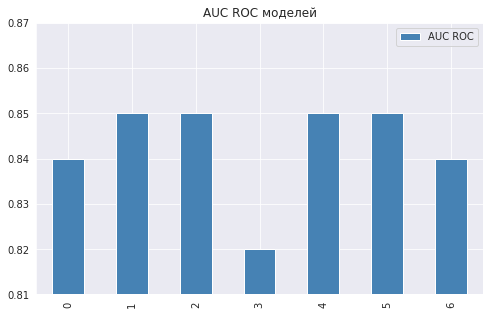

In [118]:
dt = [['RandomForest_balanced',round((gs_rf.best_score_),2) ], 
      ['RandomForest_undersample', round((rf.best_score_),2)], 
      ['RandomForest_oversampler', round((rf_ov.best_score_),2)],
      ['DecisionTree_oversampler', round((dt_ov.best_score_),2)],
      #['LGBMClassifier',round((lgbm.best_score_),2)],
      ['CatBoostClassifier',  round((cb_ov.best_score_),2)],
      ['CatBoost_original', round(pd.DataFrame(result['cv_results'])['test-AUC-mean'].max(),2)],
     ['NET-model',round((mod_metric),2)]]

v = pd.DataFrame(dt, columns=['model', 'AUC ROC'])
ax = v.plot.bar(ylim=(0.81, 0.87), title='AUC ROC моделей', figsize=(8, 5), color = 'steelblue',grid=True,) 
v

 <b> Вывод:</b>
Мы построили несколько моделей, предсказывающих вероятность расторжения договора абонентом оператора связи «ТелеДом»: RandomForest и DecisionTree с применением методов борьбы с дисбалансом классов, модели градиентного бустинга  CatBoost (с преобразованием данных и на первоначальных признаках), нейронную сеть средствами библиотеки tensorflow. За исключением найронной сети для всех моделей подбирали параметры методом GridSearchCV. Метрикой качества, в соответствии с условием проекта - ROC-AUC.
    
По условию проекта значение метрики ROC-AUC должно быть не менее 0.85. Данное значение достигнуто у моделей RandomForest (при уменьшении и увеличении выборки) и всех моделей градиентного бустинга. Следует отметить, что значение метрики находится "на грани", но по правилам математического округления оно отвечает условию проекта.
    
Самая низкая метрика качества у DecisionTree. Нейросеть никак себя не проявила.
    
Из тех моделей, что достигли нужной метрики качества остановим свой выбор на CatBoostClassifier, обученной на первоначальных признаках, который автоматически обрабатывает категориальные признаки, не требуя их предварительной обработки или кодирования, использует перекрестную энтропию в качестве метрики в процессе разделения, что позволяет улучшить точность классификации и обладает высокой скоростью работы для выполнения задач классификации на  больших объемах данных.

## Тестирование и демонстрация работы модели

Модели model_cb - CatBoostClassifier, обученной на первоначальных признаках, передим признаки из тестовой выборки и получим предсказания, на основе которых для демонстрации работы модели построим матрицу ошибок, ROC-кривую и графике Precision-Recall. Выведем метрику качества. Для интерпретируемости модели дополнительно выведем значение accuracy.

In [119]:
#получаем предсказания
cb_model_pred = model_cb.predict(test_features)

#выводим метрику качества
print("AUC ROC на тестовой выборке:", round(roc_auc_score(test_target, (model_cb.predict_proba(test_features))[:, 1]),2))

AUC ROC на тестовой выборке: 0.85


Значение метрики качества AUC ROC на тестовой выборке модели CatBoostClassifier, обученной на первоначальных признаках, составила 0.85, что отвечает условию проекта. Визуализируем ее на графике ROC-кривой.

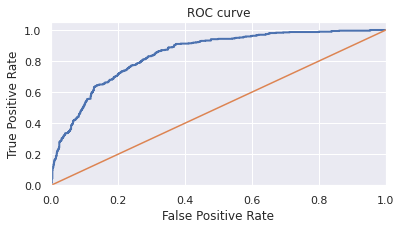

In [120]:
#код для ROC-кривой
sns.set(font_scale=1)
sns.set_color_codes("muted")
plt.figure(figsize=(6, 3))
ax = fpr, tpr, thresholds = roc_curve(test_target, model_cb.predict_proba(test_features)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

График ROC-кривой возвышается над диагональю и демонстрирует, что наша модель с соответствующим значением AUC ROC делает предсказания лучше случайной модели. 

Вычислим правильность модели функцией accuracy_score(),которая принимает на вход верные ответы и предсказания, а вернет долю правильных ответов.

In [121]:
print("accuracy:", round ((model_cb.score(test_features,test_target)),2))

accuracy: 0.8


Доля правильных ответов составляет 0.80. 

Для наглядного представления о том, какие ответы модель чаще правильно предсказывает, а в каких чаще ошибается построим матрицу ошибок методом confusion_matrix(), которому также на вход передадим правильные ответы тестовой выборки и предсказания. 

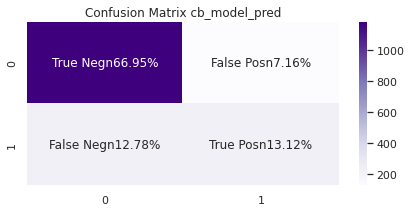

[[1179  126]
 [ 225  231]]


In [122]:
# Строим матрицу ошибок
cnf_matrix = confusion_matrix(test_target, cb_model_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_percentages = ["{0:.2%}".format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]

labels = [f"{v1}n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
plt.figure(figsize=(7, 3))
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Purples')
ax.set_title('Confusion Matrix cb_model_pred')
plt.show()
print(cnf_matrix)

На главной диагонали нашей матрицы ошибок располагаются правильные прогнозы модели: довольно высокая доля истинноотрицательных ответов - 66.95%, т.е. модель с высокой долей вероятности предскажет что клиент останется. Истинноположительные ответы составляют 13.12%. Доля ложноположительных ответов 7.16% несколько ниже доли ложноотрицательных ответов, то есть ошибка второго рода допускается чаще, чем ошибка первого рода.  

Для нахождения среднего  полноты и точности модели классификации вычислим и визуализируем F1-меру, являющуюся
средним гармоническим полноты и точности.

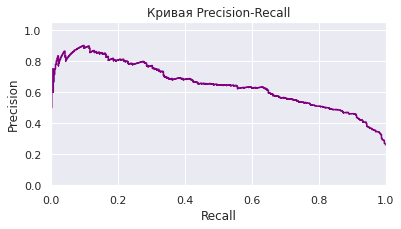

precision: 0.65
recall: 0.51
F1: 0.568


In [123]:
#код для  PR-кривой 
probabilities_valid = model_cb.predict_proba(test_features)
ax = precision, recall, thresholds = precision_recall_curve(test_target, probabilities_valid[:, 1])
plt.figure(figsize=(6, 3))
plt.step(recall, precision, where='post',color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

print("precision:", round((precision_score(test_target, cb_model_pred)),2))
print("recall:", round((recall_score(test_target,cb_model_pred)),2))
print("F1:", round ((f1_score(test_target, cb_model_pred)),3))

На графике Precision-Recall видно как по мере увеличения полноты предсказаний модели снижается ее точность, оптимальный показатель F1=0.568 достигается при значениях precision=0.65, recall=0.51.

### Анализ важности признаков

Для анализа важности признаков построим таблицу и график.

,feature,importance
0,monthly_charges,23.771775
1,total_charges,22.915315
2,type,22.716054
3,internet_service,6.460603
4,payment_method,3.888317
5,paperless_billing,3.718573
6,online_security,3.145963
7,duration_contracts,2.912382
8,tech_support,2.545836
9,streaming_movies,2.308679


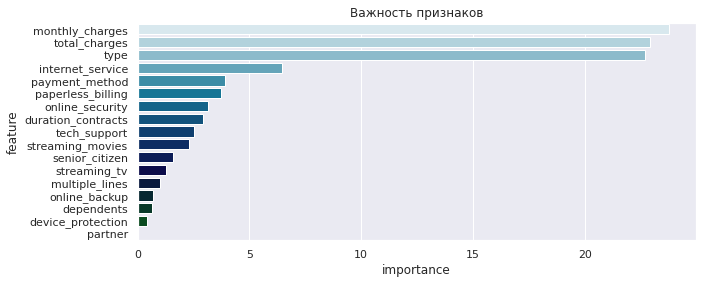

In [124]:
importances = model_cb.feature_importances_
feature_list = list(train_features.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

sns.set (font_scale= 1 )
plt.figure(figsize=[10,4])
plt.title('Важность признаков')
ax = sns.barplot(x='importance', y="feature", data=feature_results, palette='ocean_r')
feature_results

В первую по значимости тройку признаков, влияющих на отток клиентов, вошли данные об оплате абонентов за услуги связи: "monthly_charges", "total_charges", "type" (ок. 23 % каждый).

Данные о семейном положении (наличие супруга,детей), наличии таких услуг как облачное хранилище данных, антивирус имеют минимальное значение (менее 1 %).

Все остальные признаки распределились в пределах от 6 до 1 %. В их числе более выделяется признак InternetService — тип подключения.

Дополнительно исследуем такой важный признак как Type — тип оплаты. Для этого сгруппируем данные и построим график

In [125]:
# группируем данные
t_t = all_df.groupby(['type', 'target']).size().unstack()
t_t 

target,0,1
type,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


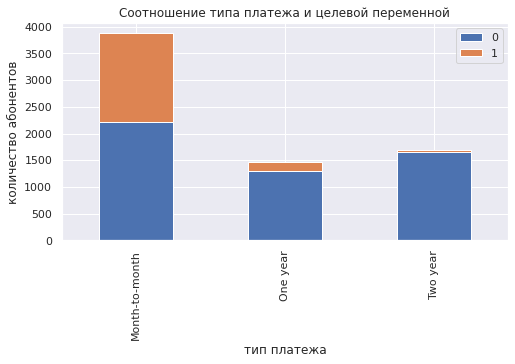

In [126]:
# Строим график зависимости
t_t.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.xlabel('тип платежа')
plt.ylabel('количество абонентов')
plt.title('Соотношение типа платежа и целевой переменной')
plt.legend(['0', '1'])

plt.show()

На графике зависимости типа платежа от целевой переменной видно, что чем чаще периодичность платежа, тем более абонент склонен к расторжению договора с оператором связи. 

Более 40% абонентов, которые платят за связь ежемесячно, меняют оператора. В числе тех, кто платит один раз в год, чуть более 12% (166 из 1473) расторгают договор с оператором. Доля же тех, кто имеет тип платежа - один раз в два года и ушел от оператора связи еще меньше - 3 % (48 из 1695).  

 <b> Вывод:</b> Мы протестировали модель CatBoostClassifier, обученную на первоначальных признаках. Метрика качества AUC ROC на тестовой выборке имеет значение  0.85, что соответствует требованию заказчика. Доля правильных ответов (accuracy) составляет 0.80. Матрица ошибок демонстрирует высокую доля истинноотрицательных ответов (66.95%), т.е. модель с высокой долей вероятности предскажет что клиент останется (иснинноположительные 13.12%). Но следует учесть, что  ошибка второго рода допускается моделью чаще, чем ошибка первого рода, что для нашего случая хуже, поскольку отрицательный класс имеет положительное значение для компании (абонент не расторгнет договор).
    
Наиболее важными признаками для предсказаний оттока клиентов являются данные об оплате за услуги связи: "monthly_charges", "total_charges", "type" (ок. 23 % каждый). Данные о семейном положении (наличие супруга,детей), наличии таких услуг как облачное хранилище данных, антивирус имеют минимальное значение (менее 1 %).Все остальные признаки распределились в пределах от 6 до 1 %. В их числе более выделяется признак InternetService — тип подключения.
    
Дополнительное исследование признака 'type' показало, что чем чаще периодичность платежа, тем более абонент склонен к расторжению договора с оператором связи. Более 40% абонентов, которые платят за связь ежемесячно, меняют оператора. В числе тех, кто платит один раз в год, их  чуть более 12% (166 из 1473). Доля же тех, кто имеет тип платежа - один раз в два года и ушел от оператора связи еще меньше - 3 % (48 из 1695).    

 <b> Итоговый вывод:</b> 
    
По заказу оператора связи «ТелеДом» мы построили модель машинного обучения,  которая будет предсказывать, разорвёт ли абонент договор. Данная модель заказчику необходима для оптимизации работы компании, направленной на предотвращение оттока клиентов. В распоряжение предоставлены персональные данные о клиентах, информация об услугах.
    
Представленные наборы данных нельзя назвать исчерпывающими. Отсутствует информация как о тарифах на услуги связи, так и то, в каких единицах (валюта, единица измерения) показаны расходы. Информация об услугах телефонии не представлена данными о виде стационарной связи (местнaя, междугородняя, междунaроднaя), которая отличается тарифами, количеством использования, а также характеристиками абонентов, которые предпочитают платить за тот или иной вид. 
    
Мы провели предварительную обработку данных, включающую приведение наименований признаков столбцов к общепринятому формату, изменение типов данных, замену пропусков. Сгенерированы новый признак 'duration_contracts' с данными о длительности договоров (в днях) и целевая переменная 'target', где 1 - абонент ушел от оператора связи, 0 - продолжает оставаться клиентом компании. Соотношение классов в целевом признаке 1/3, где 1 - клиент расторг договор и 0 - клиент остается с оператором связи.

В результате исследования соотношения ушедших и оставшихся клиентов для каждого признака определились с набором признаков для передачи для обучения. Корреляционный анализ количественных небинарных признаков показал высокую положительную корреляцию между типом платежа и общей суммой. Мультиколлинеарности целевой переменной с другими признаками не отмечается.

Исследование признаков выделило характеристики клиента, склонного к расторжению договора. Это абоненты с ежемесячным типом платежа, но при этом платят больше. Решение о расторжении договора принимают, как правило по истечении примерно 8-11 месяцев. Среди них чаще встречаются не имеющие супругов и детей, пенсионеры. У таких клиентов чаще проведена цифровая связь, но они не пользуются в полной мере ее возможностями - гораздо реже подключают дополнительные интернет-услуги. 
    
Бизнес-задачей оператора связи «ТелеДом» является удержание абонентов, потенциально склонных к расторжению договора, за счет предложений специальных условий. 
    
Перед нами стояла задача построения модели машинного обучения по предсказанию ухода клиента на основе набора данных об абонентах, имеющегося в распоряжении заказчика, получении предсказаний и оценки их метриками бинарной классификации. 
На основе выбранных признаков сформирован единый датафрейм, в который не вошли признаки,содержащие даты, 'gender', 'customer_id'. Дынные разделены на учебную и тестовую выборки в соотношении train_size=0.75. 
    
Мы построили несколько моделей, предсказывающих вероятность расторжения договора абонентом оператора связи «ТелеДом»: RandomForest и DecisionTree с применением методов борьбы с дисбалансом классов, модели градиентного бустинга CatBoost (с преобразованием данных и на первоначальных признаках). Гиперпараметры подобраны методом GridSearchCV. Метрикой качества, по условию заказчика установлена ROC-AUC.  
    
Заданное значение (ROC-AUC не менее 0.85) достигнуто у моделей RandomForest (при уменьшении и увеличении выборки) и всех моделей градиентного бустинга. Для тестирования выбрана модель CatBoostClassifier, обученная на первоначальных признаках. Критериями выбора послужили: автоматическая обработка категориальных признаков без их предварительной обработки или кодирования, использование перекрестной энтропии, улучшающей точность классификации, высокая скорость работы для выполнения задач классификации на больших объемах данных.
    
На тестовых данных ROC-AUC также имеет значение 0.85, что соответствует требованию заказчика. Доля правильных ответов (accuracy) составляет 0.80. Матрица ошибок демонстрирует высокую долю истинноотрицательных ответов (66.95%), т.е. модель с высокой долей вероятности предскажет что клиент останется (иснинноположительные 13.12%). Но следует учесть, что ошибка второго рода допускается моделью чаще, чем ошибка первого рода, что для нашего случая хуже, поскольку отрицательный класс имеет положительное значение для компании (абонент не расторгнет договор).
    
Установлено, что наиболее важными признаками для предсказаний оттока клиентов являются данные об оплате за услуги связи: "monthly_charges", "total_charges", "type" (ок. 23 % каждый). Данные о семейном положении (наличие супруга,детей), наличии таких услуг как облачное хранилище данных, антивирус имеют минимальное значение (менее 1 %).Все остальные признаки распределились в пределах от 6 до 1 %. 

Дополнительное исследование признака 'type' показало, что чем чаще периодичность платежа, тем более абонент склонен к расторжению договора с оператором связи. Более 40% абонентов, которые платят за связь ежемесячно, меняют оператора. В числе тех, кто платит один раз в год, их чуть более 12% (166 из 1473). Доля же тех, кто имеет тип платежа - один раз в два года и ушел от оператора связи еще меньше - 3 % (48 из 1695).
    
В результате проведенной работы заказчику возможно предложить для внедрения модель машинного обучения CatBoostClassifier, обученную на первоначальных признаках с подобранными гиперпараметрами: 'depth': 4, 'l2_leaf_reg': 3, 'iterations': 150, 'learning_rate': 0.1.
    
Вместе с тем, с учетом анализа важности признаков, для улучшения работы модели представляется целесообразным предоставить дополнительные признаки, связанные с оплатой, которые есть в распоряжении заказчика: 
-  информацию о тарифах (заявлена в описании что есть, по факту - нет), 
-  расходовании  услуг (использование трафика, времени телефонных разговоров по видам связи (местнaя, междугородняя, междунaроднaя). 

Самому заказчику среди абонентов, предпочитающих помесячную оплату услуг, по истечении 6 месяцев с начала пользования связью (на 8-11 мес. приходится пик расторжения договоров), с учетом личностных характеристик абонентов, склонных к уходу, целесообразно организовывать промоакции.